In [242]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy.ma as ma
import numpy.linalg as linalg
from scipy.stats.stats import pearsonr

# Estadística
from scipy import stats 
from scipy import special

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal

import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')


In [243]:
def region2(A,lat,lon,lonmin, lonmax, latmin, latmax):
    reg = np.nanmean(A[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:],axis=(1,2))
    n = reg.size
    mreg = np.nanmean(reg,axis=0)
    anom = reg.copy()*np.NaN
    for j in range(n):
            anom[j] = reg[j] - mreg
    return anom
def region(A,lon,lat,lonmin,lonmax,latmin,latmax):
    nt, nlat, nlon = A.shape
    #lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
    AN = A[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
    lon_AN= lon[(lon>lonmin)&(lon<lonmax)]
    lat_AN=lat[(lat>latmin)&(lat<latmax)]
    return lat_AN, lon_AN, AN

In [244]:
#Voy a usar los datos SST y SLP como en la practica 3
#Cargo los datos SST:
path='/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/Practica 3/Datos/'
varitmax='tmax_p10_ESP.nc'
varitmin='tmin_p10_ESP.nc'
varitn10='Tn10p_ESP_nan.nc'
varitx10='Tx10p_ESP_nan.nc'
tmax10 = xr.open_dataset(path+varitmax)
tmin10 = xr.open_dataset(path+varitmin)
tn10 = xr.open_dataset(path+varitn10)
tx10 = xr.open_dataset(path+varitx10)

In [245]:
tn10=tn10.__xarray_dataarray_variable__
tx10=tx10.__xarray_dataarray_variable__


Vamos a hacer el remallado de la matriz tn10

In [246]:
tn10_remallado=tn10.interp(lat=tn10.lat[::2]).interp(lon=tn10.lon[::2])
tn10_remallado=tn10_remallado.set_index(lon='x')
tn10_remallado=tn10_remallado.set_index(lat='y')

lon = tn10_remallado.lon
lat = tn10_remallado.lat



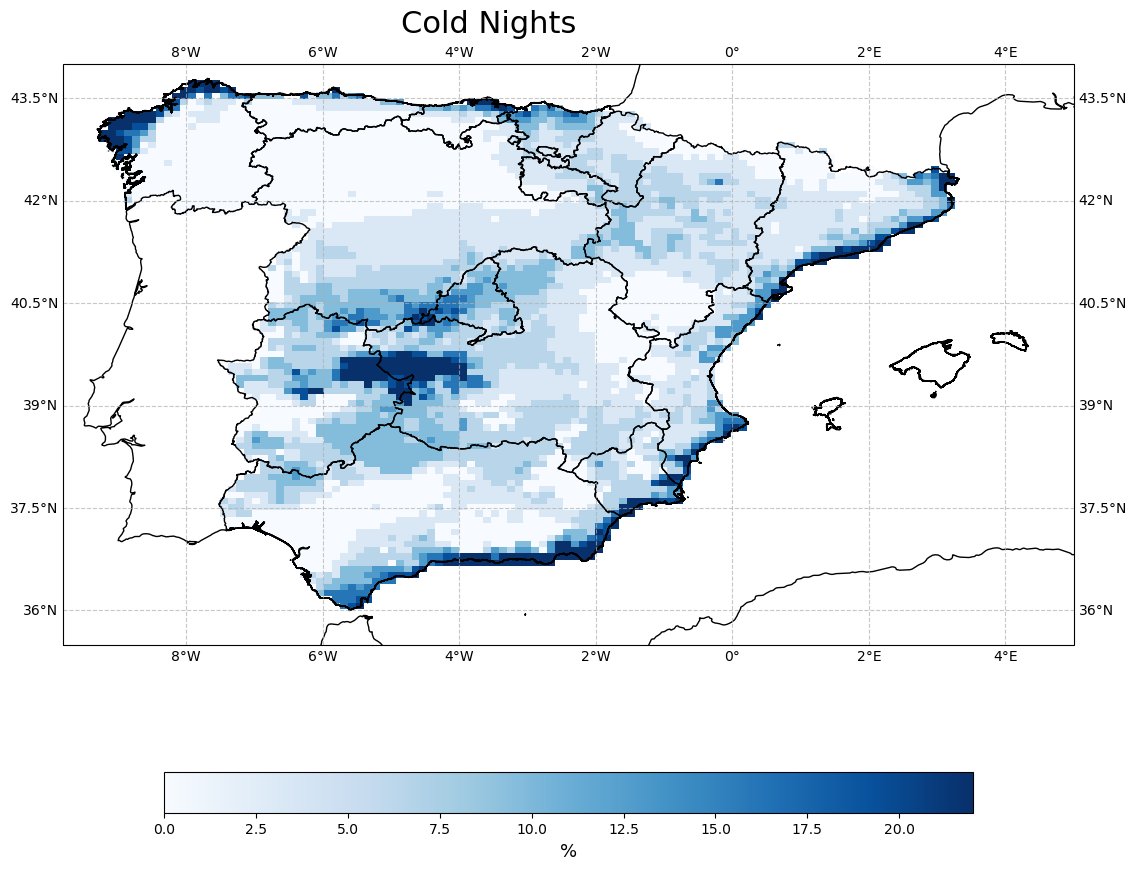

In [247]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = '../Practica 2/Codigos/Diego/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights',size=22)

# A partir de aquí vamos a pintar los valores promedio de noches frías en el periodo empleado   
cmap = 'Blues'
var = tn10_remallado.sel(time='1901-01-01')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 
#print(var.max().squeeze())

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8) 
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22) # Al poner los mismos vmin y vmax aseguramos que la escala sea consistente en cada parte

plt.tight_layout()

Agrupamos por meses para sacar la estacion que tiene mayor variabilidad, que en nuestro caso es primavera. Para ello usamos la función de Belén: season

In [248]:
nt,nlat,nlon=tn10_remallado.shape
nyears=int(nt/12)
tn10_array=np.asarray(tn10_remallado)

In [249]:
def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(
        X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

In [250]:
nlatitud=tn10_array.shape[1]
nlongitud=tn10_array.shape[2]
tn10_array.shape

(1368, 95, 115)

In [251]:
tn10_primavera_reshape=np.reshape(tn10_array, (nyears,12,nlat*nlon))
tn10_primavera,ny1=season(tn10_primavera_reshape,2,4,nyears)
tn10_primavera=anom(np.transpose(tn10_primavera),nyears,'pp')
tn10_primavera.shape
# CON ESTO COGEMOS LA ESTACION DE PRIMAVERA QUE ES LA QUE TIENE MAS ANOMALIAS EN NUETRO ÍNDICE
# LUEGO CALCULAMOS LAS ANOMALIAS CON LA FUNCIÓN DE BELEN

(10925, 114)

In [252]:
tn10_primavera=np.transpose(tn10_primavera)
tn10_primavera.shape
# La transponemos para obtener TIEMPO ESPACIO para utilizar la función de quitonans

(114, 10925)

In [253]:
def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out


In [254]:
tn10_primavera_sin_nan=quitonans(tn10_primavera)
tn10_primavera_sin_nan.shape
# Ahora tenemos una matriz TIEMPO ESPACIO sin los valores nan

(114, 5049)

In [255]:
C=np.dot(np.transpose(tn10_primavera_sin_nan),tn10_primavera_sin_nan)
# C tiene que ser una matriz ESPACIO-ESPACIO

In [256]:
C.shape
# Vemos que tiene dimensiones espacio espacio

(5049, 5049)

In [257]:
eof_tn10,d_tn10,eof2_tn10=linalg.svd(C)
# El campo derecho y el izquierdo tienen la misma dimensión, cualquiera de los dos dará lo mismo
# Se tendrá una matriz diagonal con las dimesniones del espacio, solo interesan los primeros autovalores

In [258]:
fvar_tn10=(d_tn10)/sum(d_tn10)

sum(fvar_tn10[:10])

# Los 10 primeros autovalores nos dan el 85 % de la variabilidad

0.8533505472138712

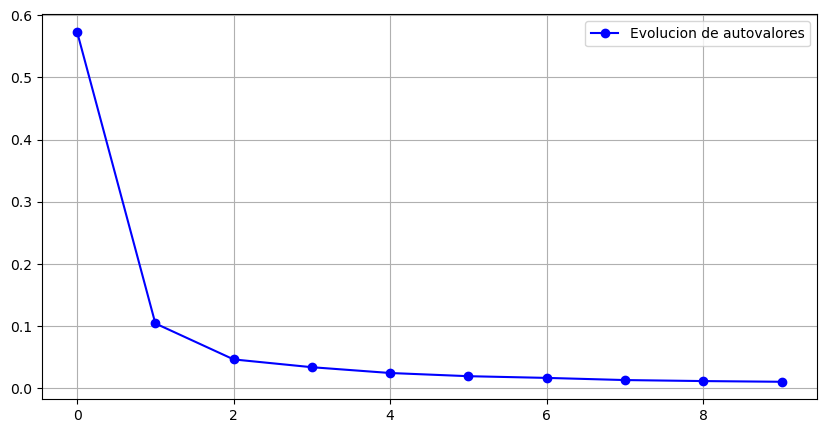

In [259]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar_tn10[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

In [260]:
PC=np.dot(tn10_primavera_sin_nan,eof_tn10[:,:8])

In [261]:
PC.shape

(114, 8)

In [262]:
PCs=(PC-np.mean(PC))/np.std(PC)

In [263]:
def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

Text(0.5, 1.0, 'Primera componente principal fvar=0.57')

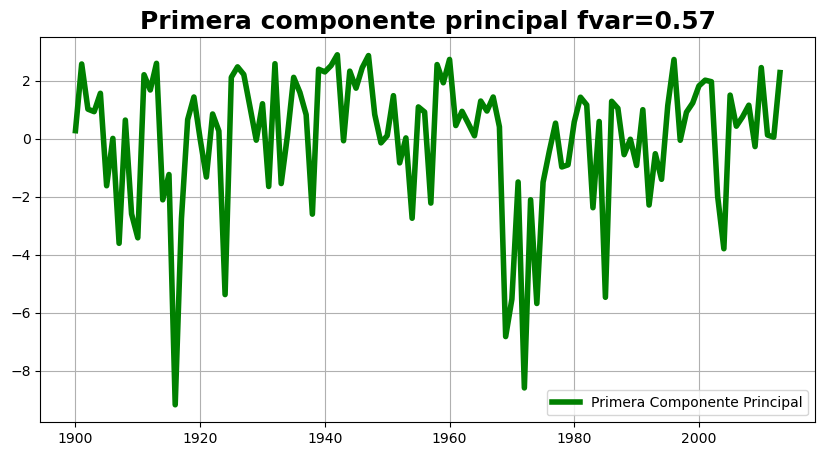

In [264]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs[:,0],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal fvar='+ str( round(fvar_tn10[0],2)),fontsize=18,weight='bold')

0.42105263157894735
[0.27804949271491886 2.5777587097892307 1.02041691893926 0.93390515607612
 1.5670752819878888 -1.6207870098279737 0.01152006321912966
 -3.6047889029394877 0.6428480932118723 -2.5907372274252274
 -3.415769682446851 2.2066507963168727 1.6803897958376972
 2.600164964910043 -2.1059197903832914 -1.232739276862861
 -9.170599912086356 -2.7527135084150878 0.6616077076436969
 1.4393301982859776 -0.007516829545488553 -1.319572706119926
 0.8535025412327236 0.2674332708855948 -5.371785828397613
 2.1179975183903545 2.477686151125315 2.214643165695626 1.0876809373280765
 -0.050138816051202365 1.2070693288171048 -1.645110918717915
 2.5864769382571824 -1.5445239543352465 0.11098316004223385
 2.116492281970748 1.5965225390940982 0.8298461857499101
 -2.599190230429055 2.3964470583525213 2.304562317214326 2.522895246571371
 2.8944389811126037 -0.0687467686685788 2.330270572397809
 1.7435994983284229 2.450140453899869 2.867350091177154 0.8370838264364743
 -0.14225979062649874 0.1052595

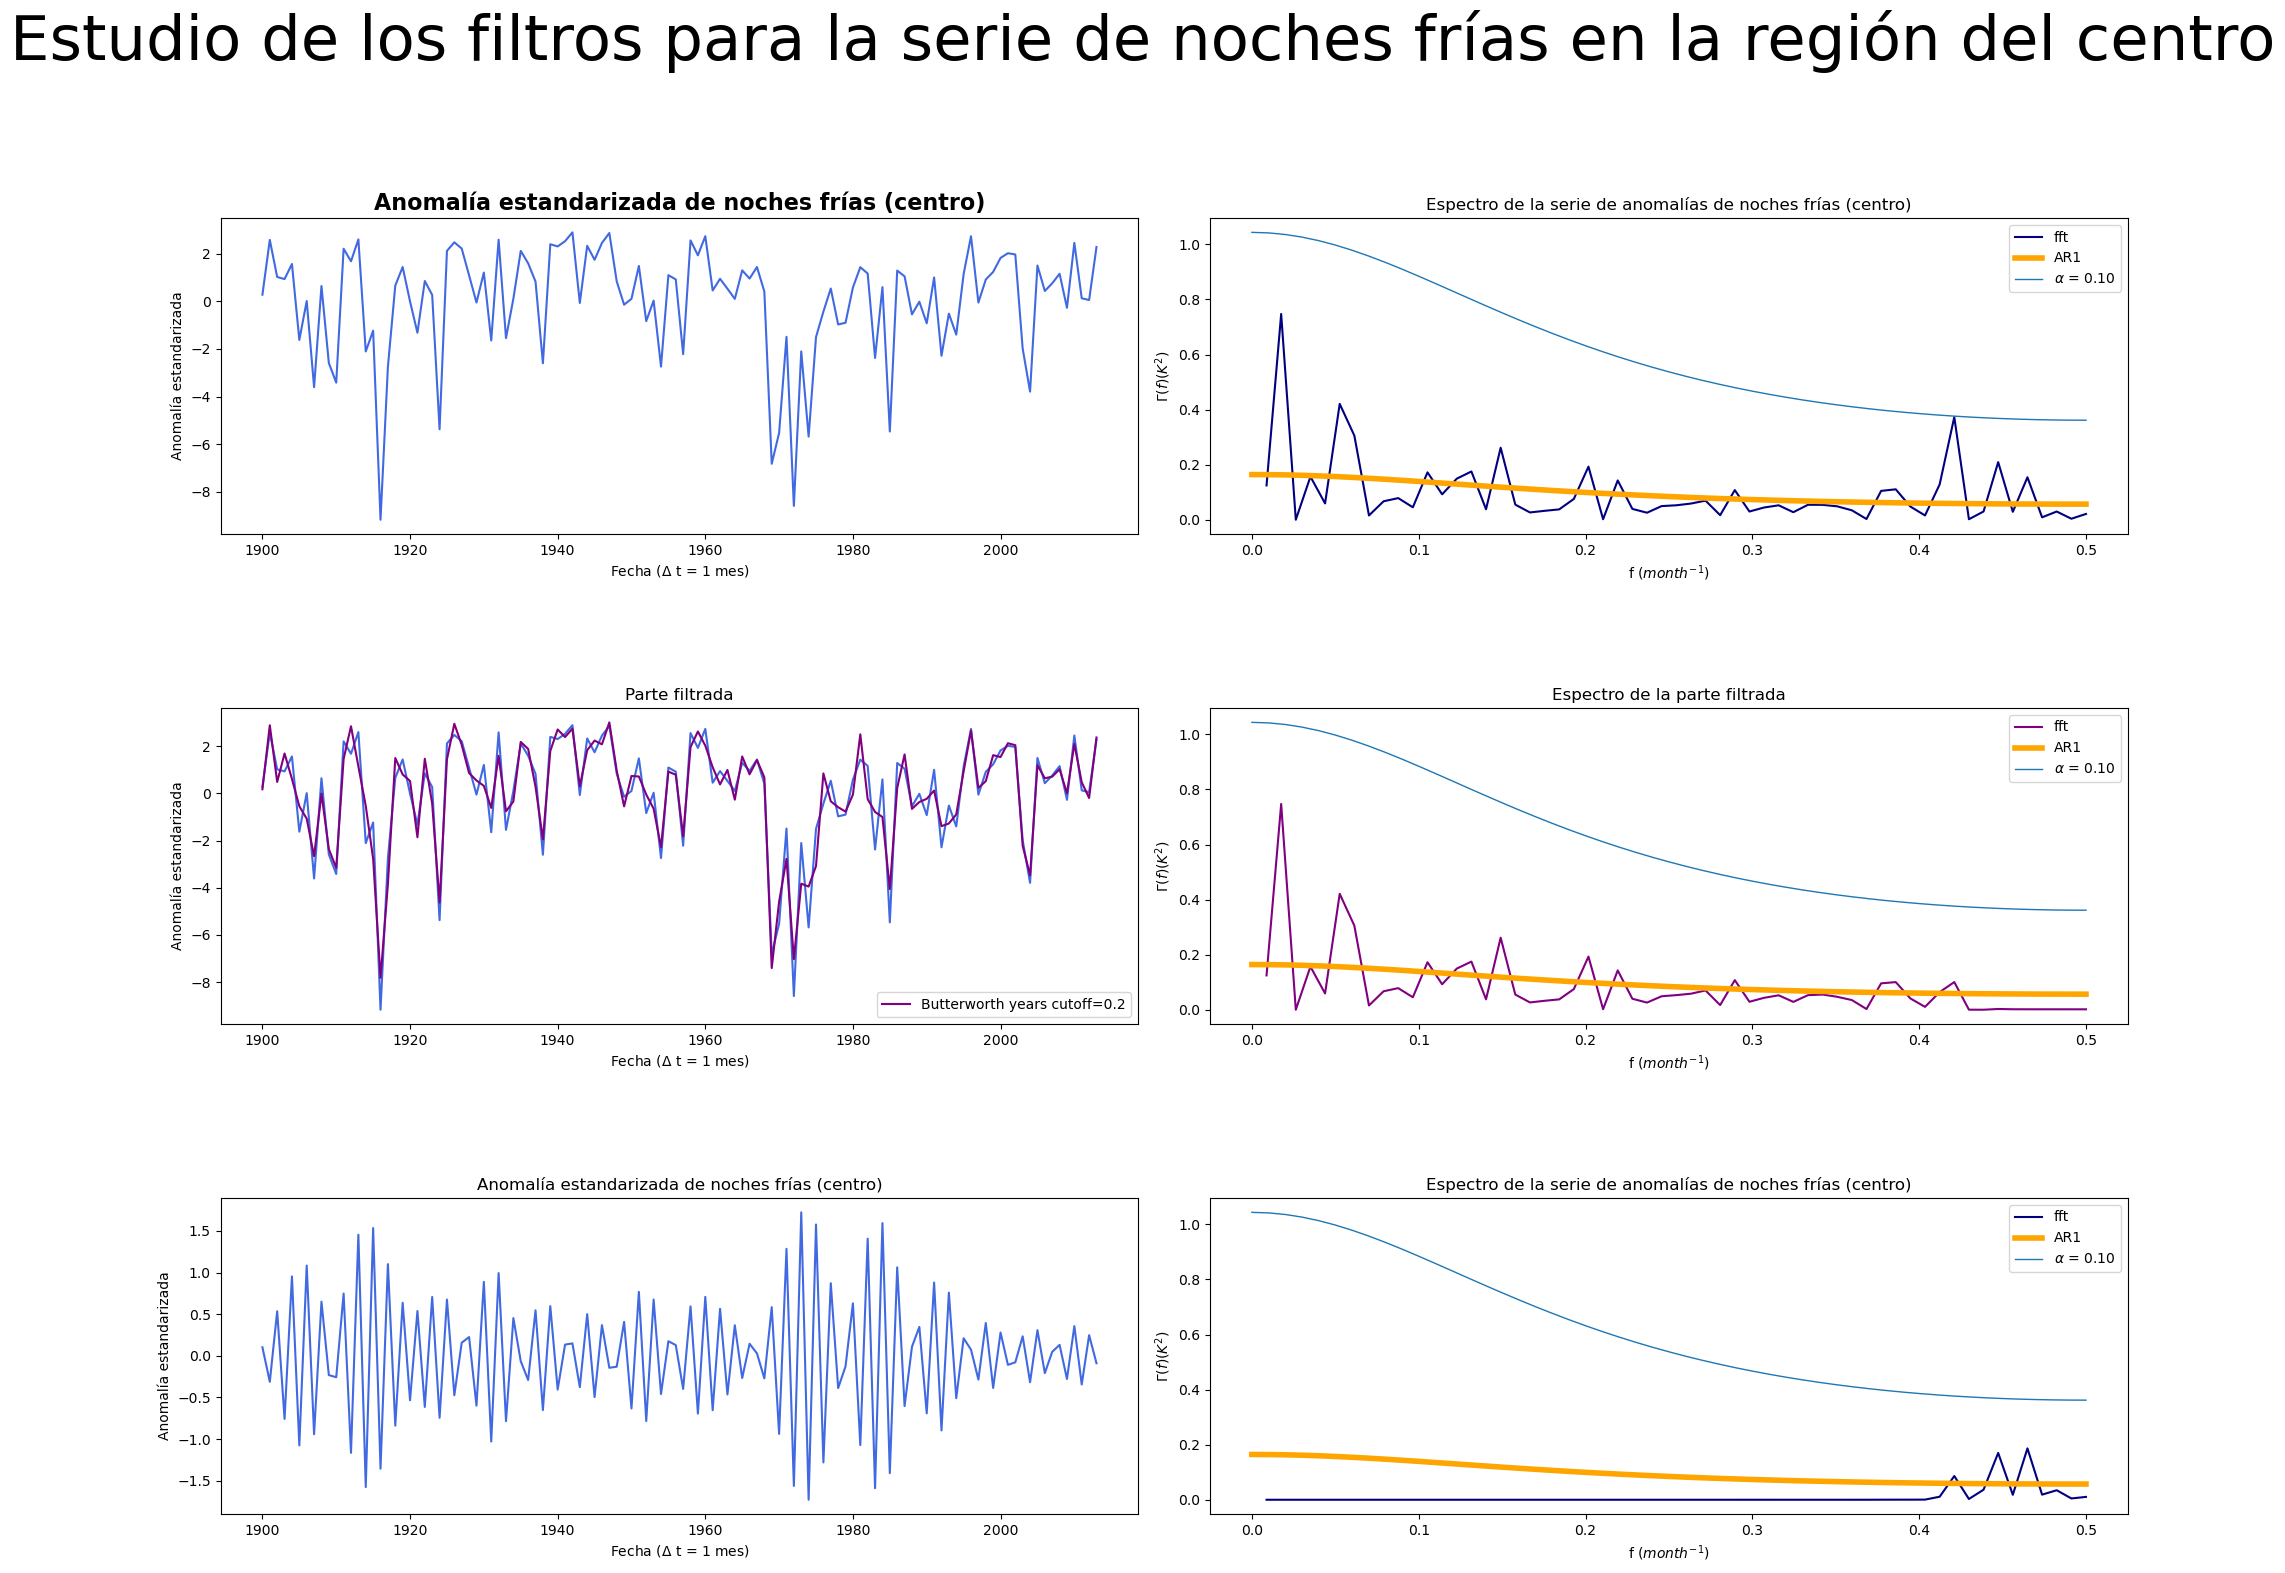

In [265]:
fig,(ax,ax3,axd)=plt.subplots(3,2,figsize=(20,16))
años=np.arange(1900,2014)
var = PCs[:,0]
x=var
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title('Anomalía estandarizada de noches frías (centro)',fontsize=16,weight='bold')

# Calculamos el espectro de la serie inicial
ff,Gf = espectroFFT(x,1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')

ff_d = ff 
Gf_d = Gf 

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x0=np.where(Gf>0.3)
frec=ff[x0]
Gf_pico=Gf[x0]
1/frec/12
frec_mens_diasf=ff[x0][-1]
print(frec_mens_diasf)
# Ahora solo lo que hemos filtrado
#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,2*frec_mens_diasf,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
xtotx_men_dias = np.append(np.flip(x),[x,np.flip(x)])
ytotx_men_dias = signal.filtfilt(b,a,xtotx_men_dias)
yButterx_men_dias = ytotx_men_dias[N:2*N]

x = yButterx_men_dias
ax3[0].plot(años,PCs[:,0],color='royalblue')
nyc=1/frec_mens_diasf/12
ax3[0].plot(años,x,color='Purple',label='Butterworth years cutoff='+str(np.float(np.round(nyc,2))))

ax3[0].set_ylabel(u'Anomalía estandarizada')
ax3[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax3[0].set_title(u'Parte filtrada')
ax3[0].legend()

# Calculamos el espectro de la serie filtrada
ff,Gf = espectroFFT(x,1)
ax3[1].plot(ff,Gf,label='fft',color='Purple')
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro de la parte filtrada')


ax3[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
ax3[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
ax3[1].legend()


# La señal quitando los picos significativos
print(var)
x = var-yButterx_men_dias
axd[0].plot(años,x,color='royalblue')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (centro)')

# Calculamos el espectro de la srie inicial menos la parte filtrada
ff,Gf = espectroFFT(x,1)
axd[1].plot(ff,Gf,label='fft',color='navy')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')


axd[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
axd[1].legend()

plt.suptitle('Estudio de los filtros para la serie de noches frías en la región del centro',fontsize=45)


plt.tight_layout()
grid = plt.GridSpec(3,3)
fig.tight_layout()
plt.subplots_adjust(hspace=0.55,top=0.85)
# plt.savefig('filtros_mensual_noches_frias.png')

In [266]:
primer_pico_P1=np.where(PCs[:,0]<-6)[0][0]


Text(0.5, 1.0, 'Segunda componente principal fvar=0.1')

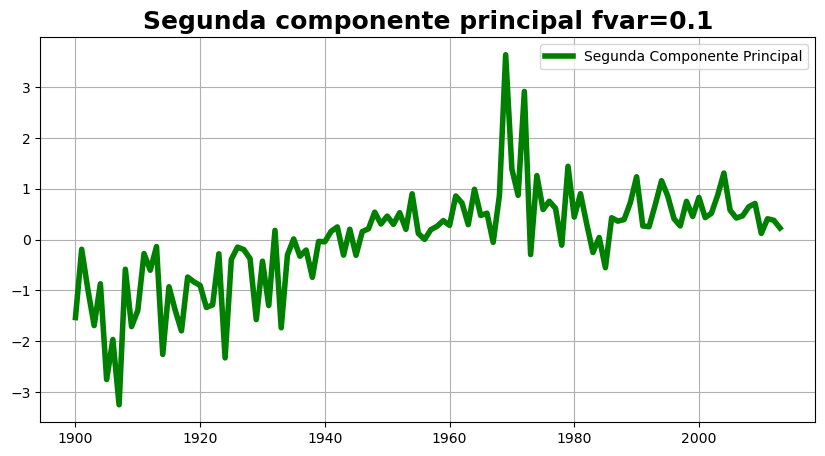

In [267]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs[:,1],linewidth= 4,color='green',label='Segunda Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Segunda componente principal fvar='+ str( round(fvar_tn10[1],2)),fontsize=18,weight='bold')


[-1.5347040418209792 -0.1904879325985609 -0.9879447448315847
 -1.6934232621080128 -0.8702166377238815 -2.755481557605724
 -1.966575141048524 -3.2515760367727173 -0.5839533839170269
 -1.7135599008241005 -1.394926237115448 -0.27557947142979183
 -0.6036269966807724 -0.1377682405172574 -2.2602376463504683
 -0.9285934381801882 -1.390396578362816 -1.7962175363624246
 -0.7376648644665186 -0.8325727300841089 -0.9026007380419878
 -1.3362243469396744 -1.28604335912369 -0.28069520377058527
 -2.328302542665758 -0.38907839756511264 -0.1492108519534664
 -0.19698601303011457 -0.37377070061856393 -1.5753523194625447
 -0.4251411534429984 -1.2985052012808596 0.18057991576902857
 -1.735666139515832 -0.30360490811033686 0.012051173285207911
 -0.3272341940027889 -0.20591744850116456 -0.7435850576286094
 -0.03711759636862391 -0.042383121413368356 0.1611792682136457
 0.24869586256047893 -0.30593334860301746 0.20352972372778835
 -0.3092496752797088 0.15679277958266277 0.21305371886723956
 0.5397252555734373 0

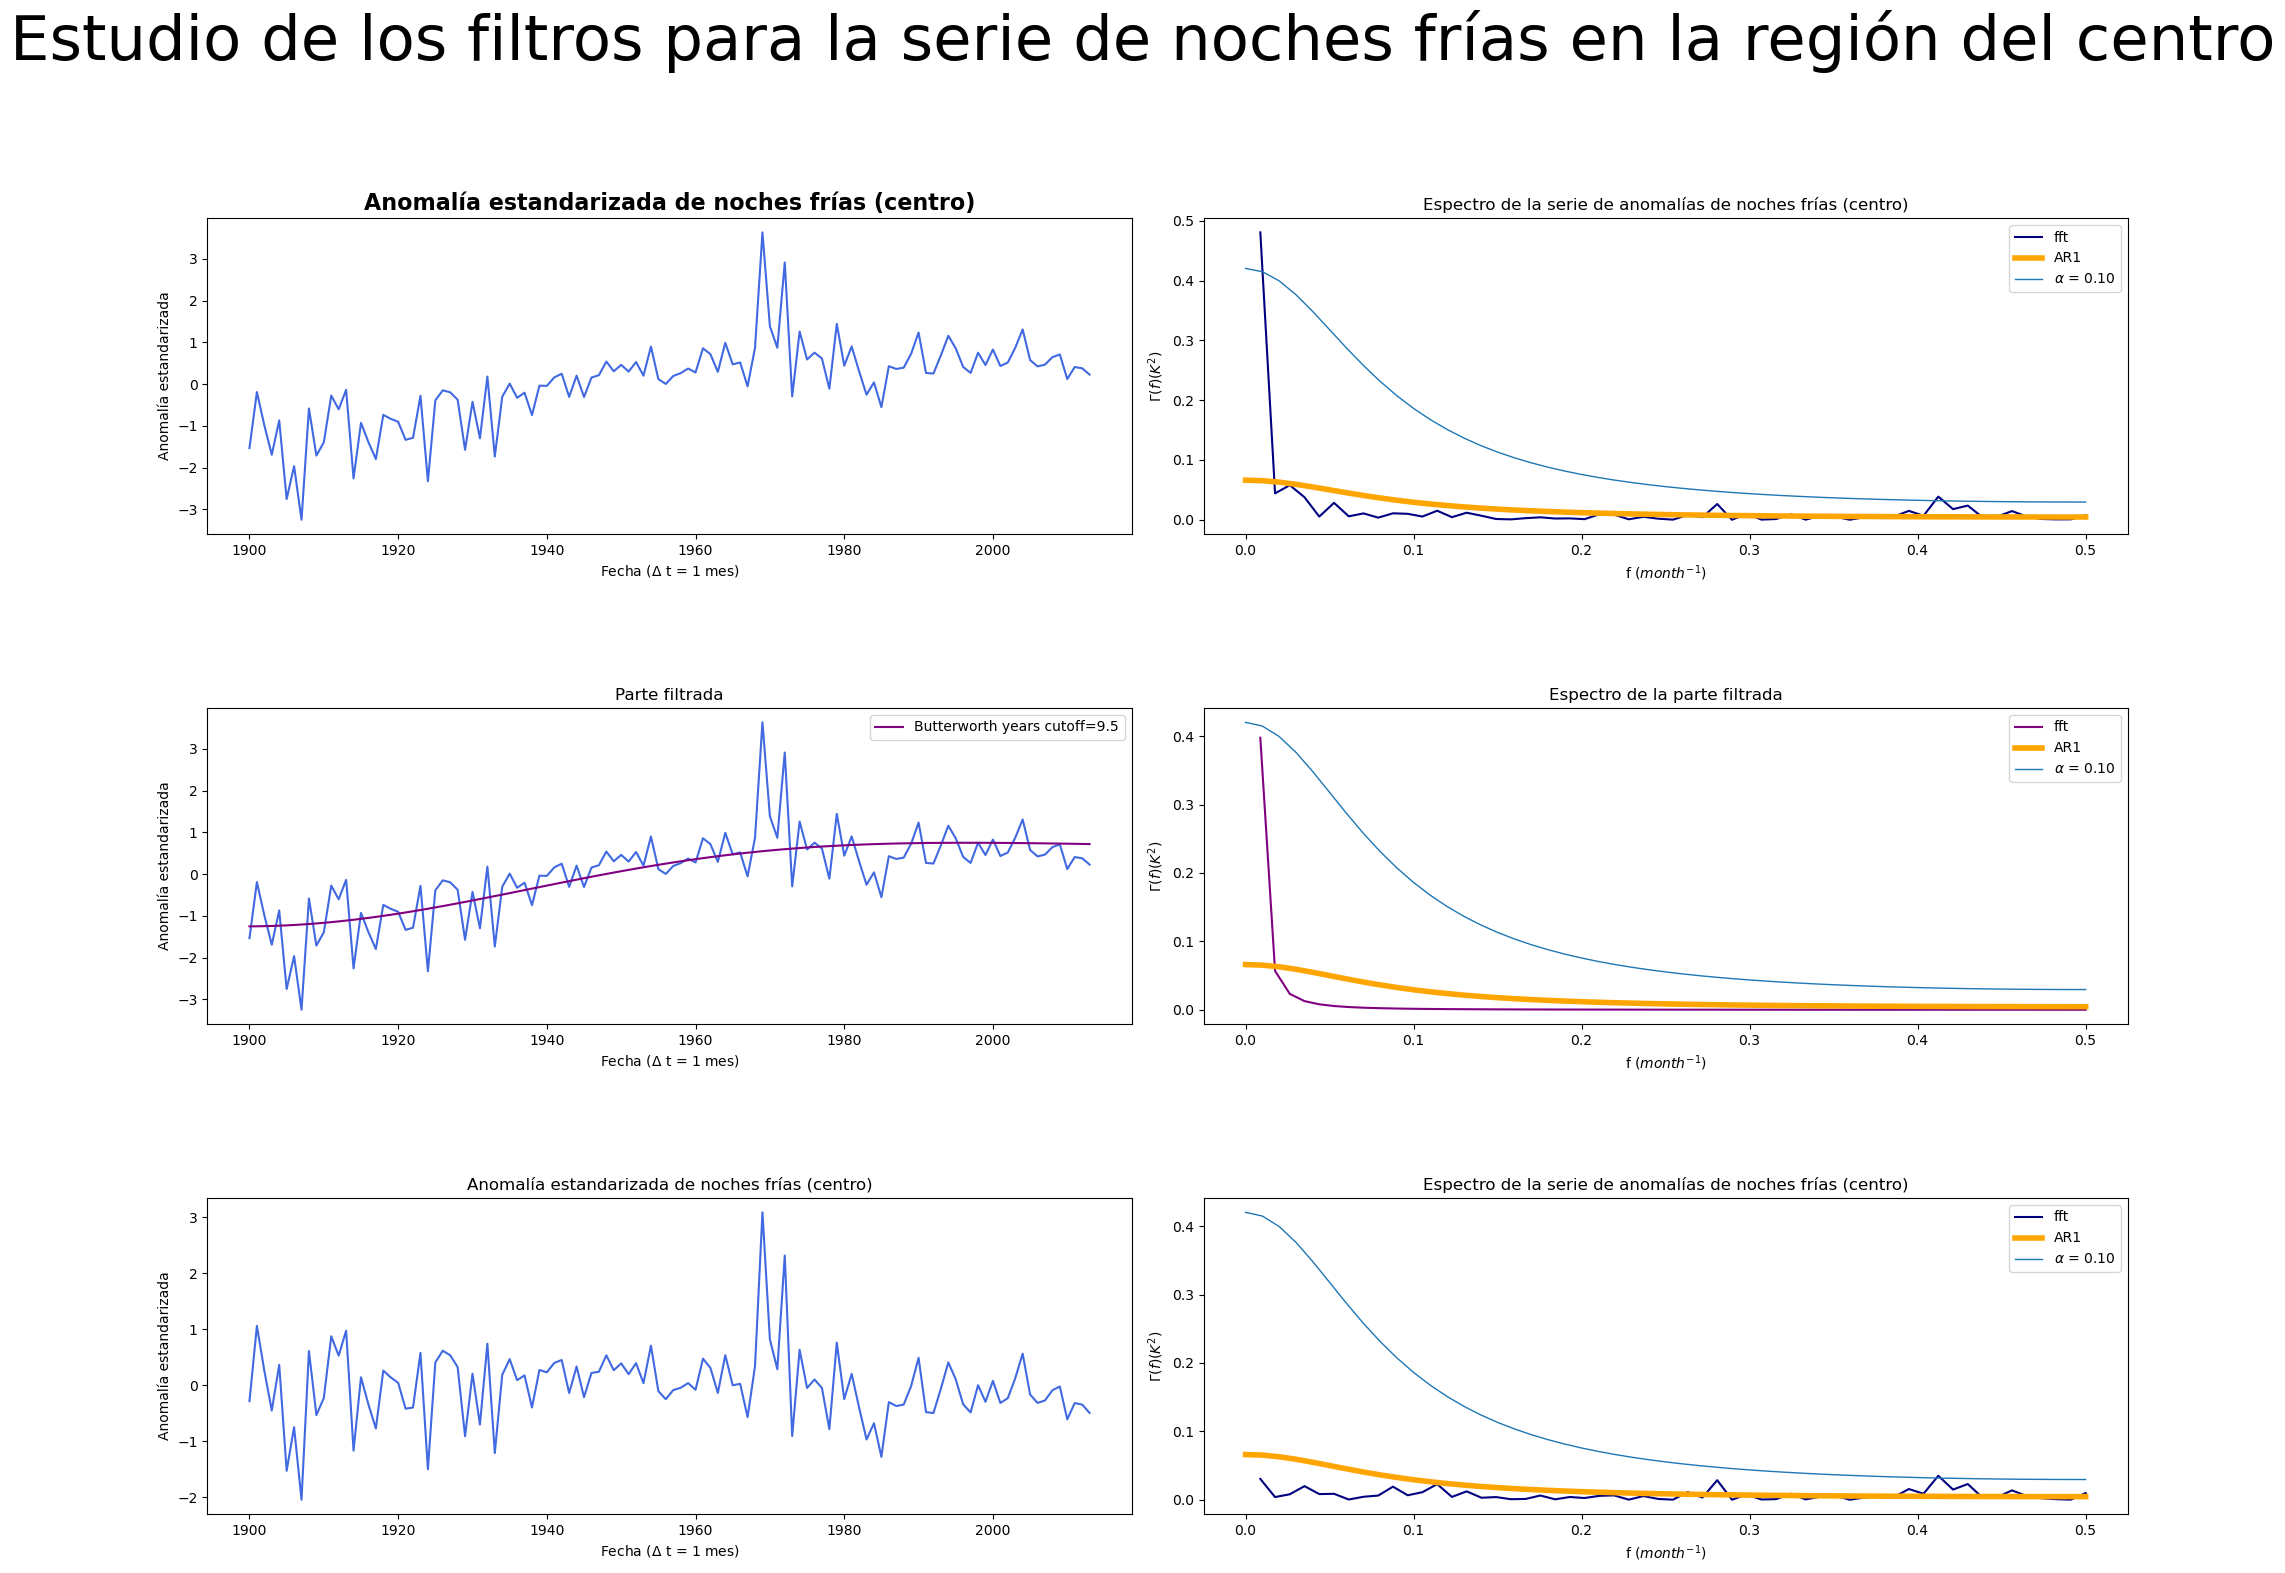

In [268]:
fig,(ax,ax3,axd)=plt.subplots(3,2,figsize=(20,16))
años=np.arange(1900,2014)
var = PCs[:,1]
x=var
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title('Anomalía estandarizada de noches frías (centro)',fontsize=16,weight='bold')

# Calculamos el espectro de la serie inicial
ff,Gf = espectroFFT(x,1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')

ff_d = ff 
Gf_d = Gf 

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x0=np.where(Gf>0.4)
frec=ff[x0]
Gf_pico=Gf[x0]
1/frec/12
frec_mens_diasf=ff[x0]
frec_mens_diasf

# Ahora solo lo que hemos filtrado
#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,2*frec_mens_diasf,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
xtotx_men_dias = np.append(np.flip(x),[x,np.flip(x)])
ytotx_men_dias = signal.filtfilt(b,a,xtotx_men_dias)
yButterx_men_dias = ytotx_men_dias[N:2*N]

x = yButterx_men_dias
ax3[0].plot(años,PCs[:,1],color='royalblue')
nyc=1/frec_mens_diasf/12
ax3[0].plot(años,x,color='Purple',label='Butterworth years cutoff='+str(np.float(np.round(nyc,2))))

ax3[0].set_ylabel(u'Anomalía estandarizada')
ax3[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax3[0].set_title(u'Parte filtrada')
ax3[0].legend()

# Calculamos el espectro de la serie filtrada
ff,Gf = espectroFFT(x,1)
ax3[1].plot(ff,Gf,label='fft',color='Purple')
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro de la parte filtrada')


ax3[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
ax3[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
ax3[1].legend()


# La señal quitando los picos significativos
print(var)
x = var-yButterx_men_dias
axd[0].plot(años,x,color='royalblue')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (centro)')

# Calculamos el espectro de la srie inicial menos la parte filtrada
ff,Gf = espectroFFT(x,1)
axd[1].plot(ff,Gf,label='fft',color='navy')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))
axd[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
axd[1].legend()

plt.suptitle('Estudio de los filtros para la serie de noches frías en la región del centro',fontsize=45)


plt.tight_layout()
grid = plt.GridSpec(3,3)
fig.tight_layout()
plt.subplots_adjust(hspace=0.55,top=0.85)
# plt.savefig('filtros_mensual_noches_frias.png')


Text(0.5, 1.0, 'Tercera componente principal fvar=0.05')

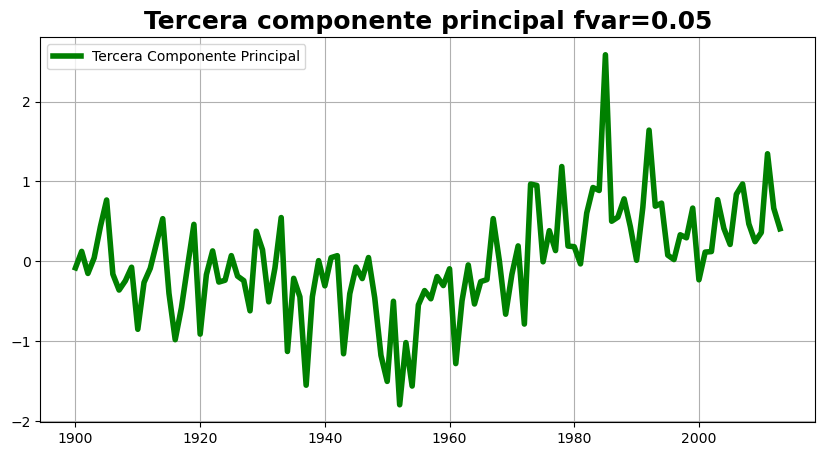

In [269]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs[:,2],linewidth= 4,color='green',label='Tercera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Tercera componente principal fvar='+ str( round(fvar_tn10[2],2)),fontsize=18,weight='bold')


La varianza de la serie es  0.4459259521278239
La integral del espectro es  0.44995977554125655
[0.00877193]
La varianza de la serie es  0.10664402940789353
La integral del espectro es  0.10665747334612102
La varianza de la serie es  0.3033979102779166
La integral del espectro es  0.3069794288870523


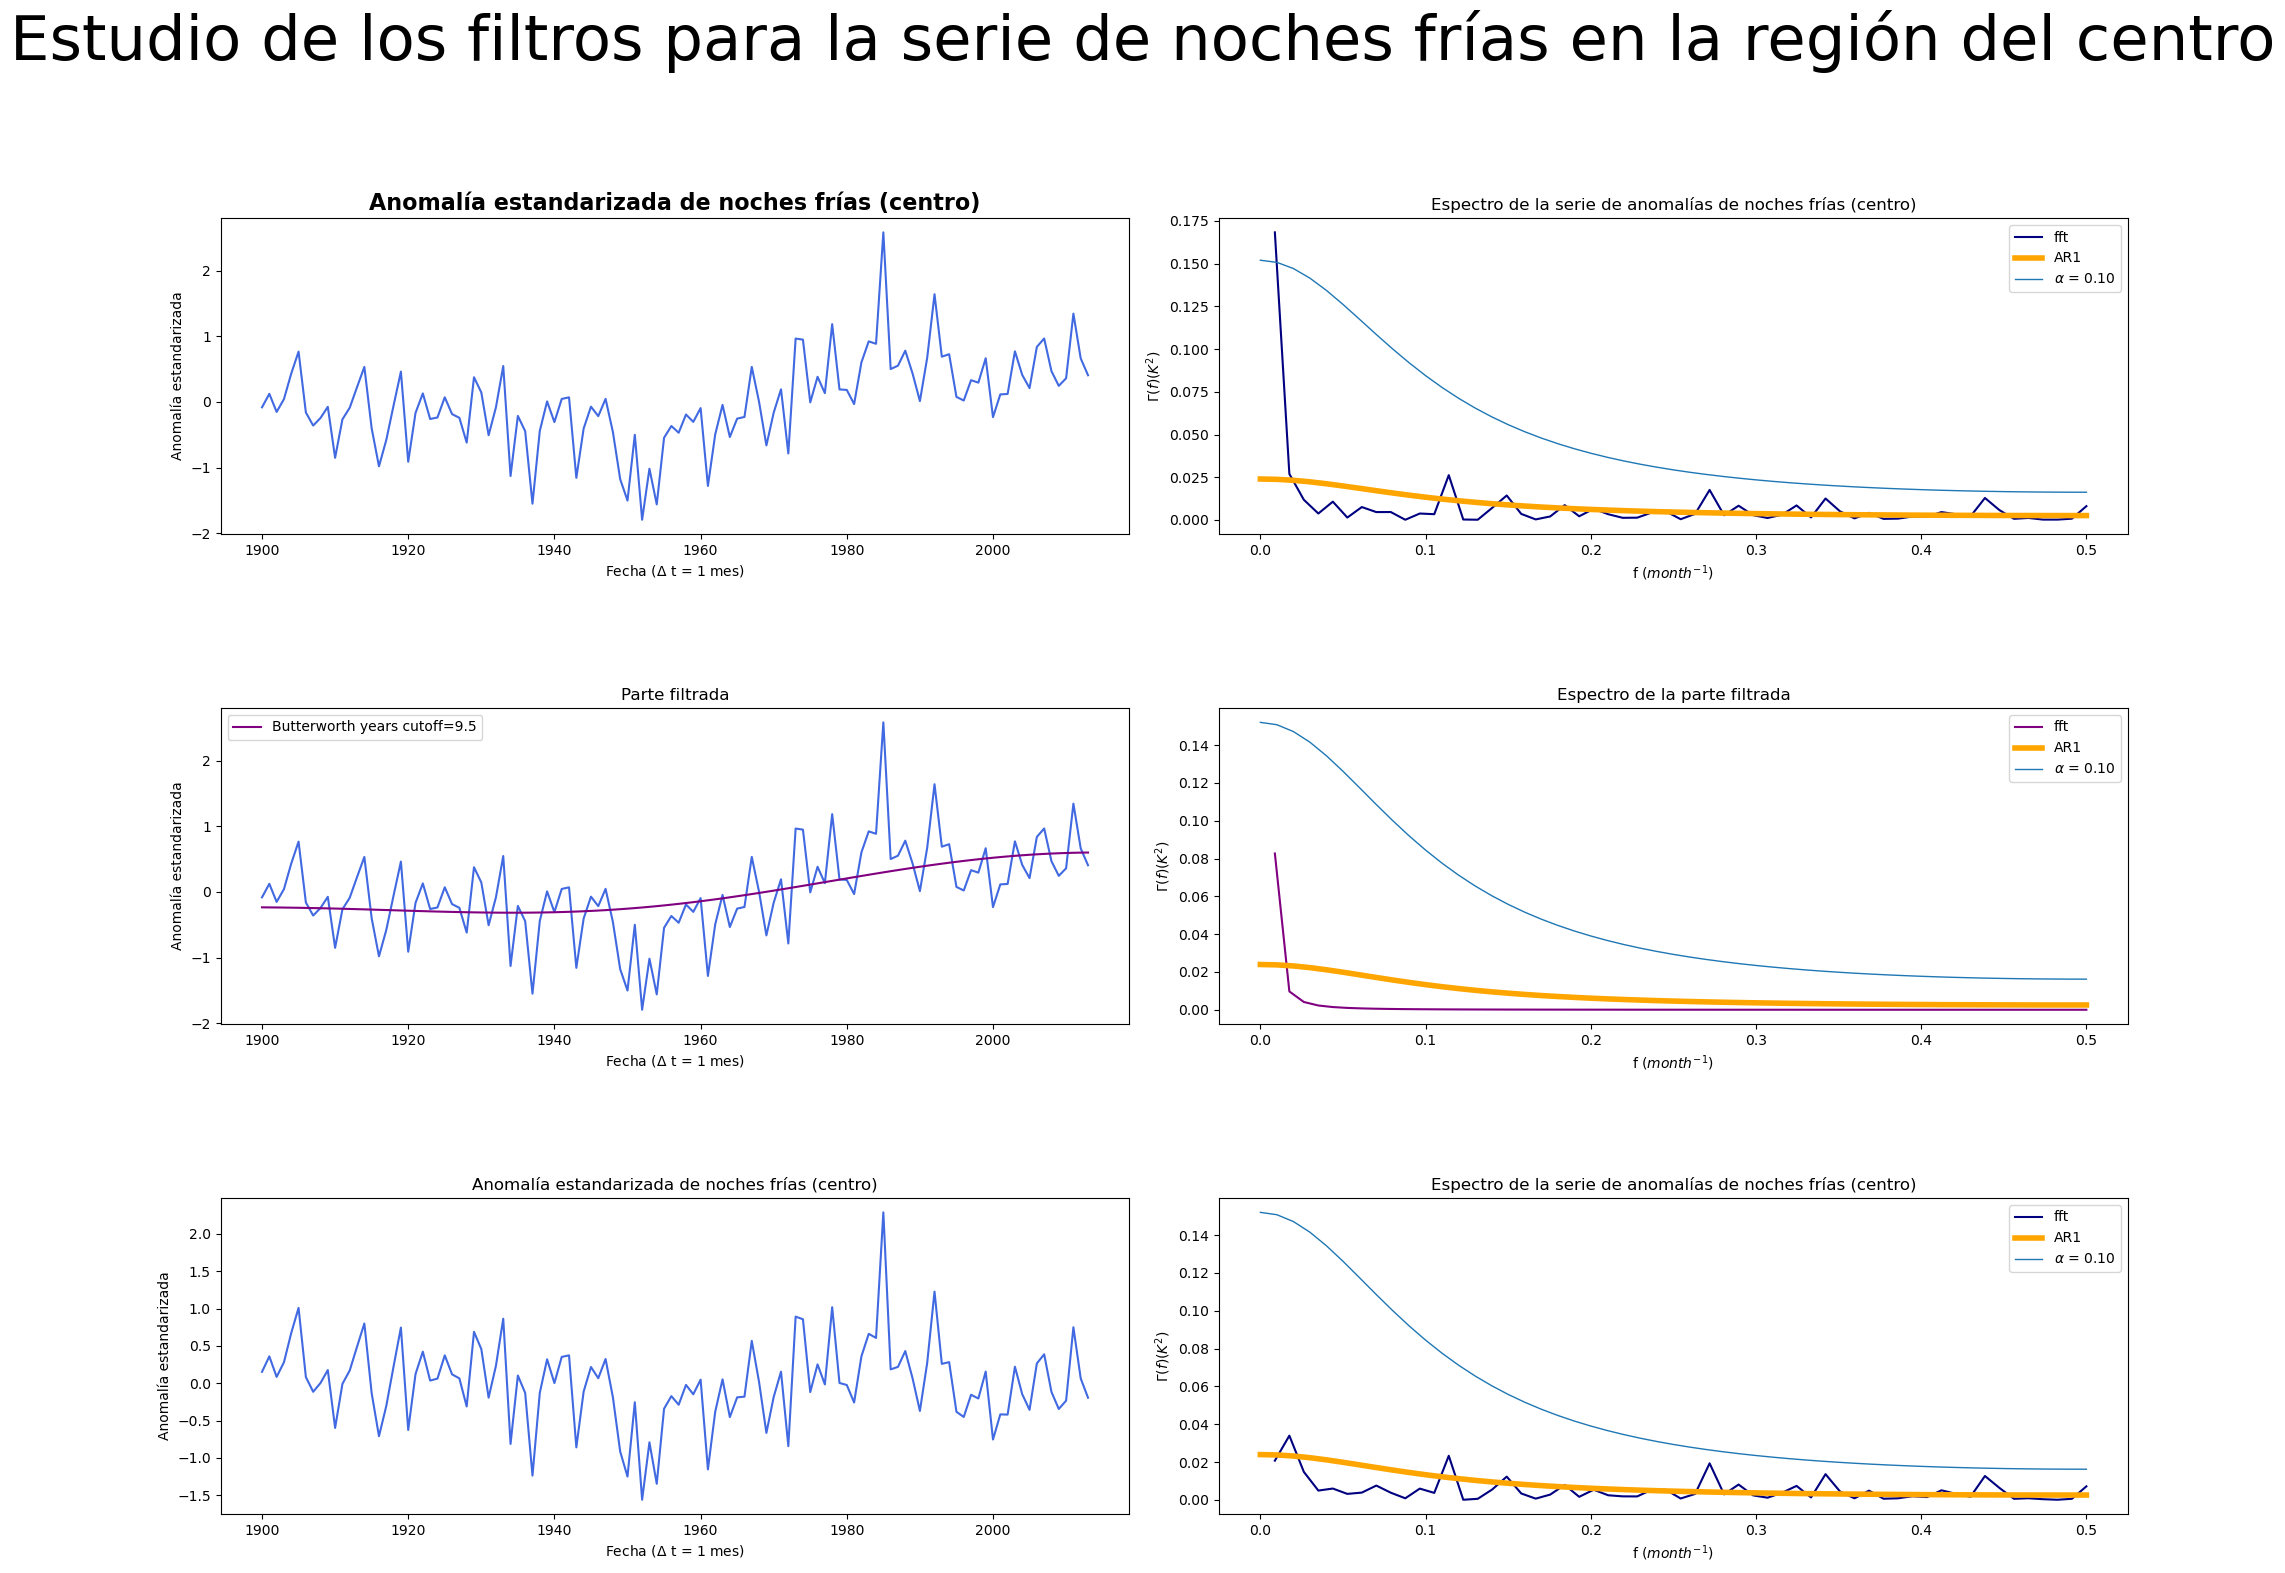

In [270]:
fig,(ax,ax3,axd)=plt.subplots(3,2,figsize=(20,16))

var= PCs[:,2]
x=var
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title('Anomalía estandarizada de noches frías (centro)',fontsize=16,weight='bold')

# Calculamos el espectro de la serie inicial
ff,Gf = espectroFFT(x,1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')

ff_d = ff 
Gf_d = Gf 

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x0=np.where(Gf>0.150)
frec=ff[x0]
Gf_pico=Gf[x0]
1/frec/12
frec_mens_diasf=ff[x0]
print(frec_mens_diasf)

# Ahora solo lo que hemos filtrado
#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,2*frec_mens_diasf,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
xtotx_men_dias = np.append(np.flip(x),[x,np.flip(x)])
ytotx_men_dias = signal.filtfilt(b,a,xtotx_men_dias)
yButterx_men_dias = ytotx_men_dias[N:2*N]

x = yButterx_men_dias
ax3[0].plot(años,var,color='royalblue')
nyc=1/frec_mens_diasf/12
ax3[0].plot(años,x,color='Purple',label='Butterworth years cutoff='+str(np.float(np.round(nyc,2))))

ax3[0].set_ylabel(u'Anomalía estandarizada')
ax3[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax3[0].set_title(u'Parte filtrada')
ax3[0].legend()

# Calculamos el espectro de la serie filtrada
ff,Gf = espectroFFT(x,1)
ax3[1].plot(ff,Gf,label='fft',color='Purple')
ax3[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax3[1].set_xlabel(r'f ($month^{-1}$)')
ax3[1].set_title('Espectro de la parte filtrada')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))
ax3[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
ax3[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
ax3[1].legend()


# La señal quitando los picos significativos
x = var-yButterx_men_dias
axd[0].plot(años,x,color='royalblue')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (centro)')

# Calculamos el espectro de la srie inicial menos la parte filtrada
ff,Gf = espectroFFT(x,1)
axd[1].plot(ff,Gf,label='fft',color='navy')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (centro)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))
axd[1].plot(f,G/x.size,linewidth=4,label='AR1',color='orange')
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
axd[1].legend()

plt.suptitle('Estudio de los filtros para la serie de noches frías en la región del centro',fontsize=45)


plt.tight_layout()
grid = plt.GridSpec(3,3)
fig.tight_layout()
plt.subplots_adjust(hspace=0.55,top=0.85)
# plt.savefig('filtros_mensual_noches_frias.png')

In [271]:
def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    #Index tiene que estar estandarizado, es decir, dividido por la desviación tipica
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig

def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2);
    ax.set_title(titulo,fontsize=28)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.7, format="%2.1f")
    cbar.set_label(l1, size=28)
    cbar.ax.tick_params(labelsize=28) 
# Esta función te sirve para dibujar en una misma figura dos mapas superpuestos, como podría ser
# el caso de un mapa A de regresion y un mapa B de correlacion significativa, del que solo te interesa
# las regiones donde es significativa la señal
def dibujo_2_mapas_cartopy_hatches(A,B,lon,lat, levs, cmap1, l1, t1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
    
    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon)), 
                     extend='both',cmap=cmap1,levels=levs,transform = ccrs.PlateCarree())

    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores
    im = ax.contourf(lon,lat,B.reshape(len(lat),len(lon))
                 ,extend='both'
                 ,hatches='.',cmap=cmap1,alfa=0,levels=levs,transform = ccrs.PlateCarree())
    #el uso de alfa=0 lo que hace es que solo salgan los puntos y no salgan los colors porque los pones totalmente transparentes
    ax.set_ylim(lat[-1], lat[0])
    ax.set_xlim(lon[0], lon[-1])

In [272]:
PCs.shape

(114, 8)

In [273]:
cor1,Pvalue1,cor_sig1,reg1,reg1_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,0]),0.01,'MonteCarlo',100)
cor2,Pvalue2,cor_sig2,reg2,reg2_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,1]),0.01,'MonteCarlo',100)
cor3,Pvalue3,cor_sig3,reg3,reg3_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,2]),0.01,'MonteCarlo',100)
# cor4,Pvalue4,cor_sig4,reg4,reg4_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,3]),0.01,'MonteCarlo',100)
# cor5,Pvalue5,cor_sig5,reg5,reg5_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,4]),0.01,'MonteCarlo',100)
# cor6,Pvalue6,cor_sig6,reg6,reg6_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,5]),0.01,'MonteCarlo',100)
# cor7,Pvalue7,cor_sig7,reg7,reg7_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,6]),0.01,'MonteCarlo',100)


In [274]:
mat=np.expand_dims((tn10_primavera)[0],axis=0)

In [275]:
reg1_final=pongonans(np.squeeze(reg1),mat)
reg_sig_1_final=pongonans(np.squeeze(reg1_sig),mat)

cor1_final=pongonans(np.squeeze(cor1),mat)
cor_sig1_final=pongonans(np.squeeze(cor_sig1),mat)


reg2_final=pongonans(np.squeeze(reg2),mat)
reg_sig_2_final=pongonans(np.squeeze(reg2_sig),mat)

reg3_final=pongonans(np.squeeze(reg3),mat)
reg_sig_3_final=pongonans(np.squeeze(reg3_sig),mat)

# reg4_final=pongonans(np.squeeze(reg4),mat)
# reg_sig_4_final=pongonans(np.squeeze(reg4_sig),mat)

# reg5_final=pongonans(np.squeeze(reg4),mat)
# reg_sig_5_final=pongonans(np.squeeze(reg5_sig),mat)

# reg6_final=pongonans(np.squeeze(reg6),mat)
# reg_sig_6_final=pongonans(np.squeeze(reg6_sig),mat)

# reg7_final=pongonans(np.squeeze(reg7),mat)
# reg_sig_7_final=pongonans(np.squeeze(reg7_sig),mat)

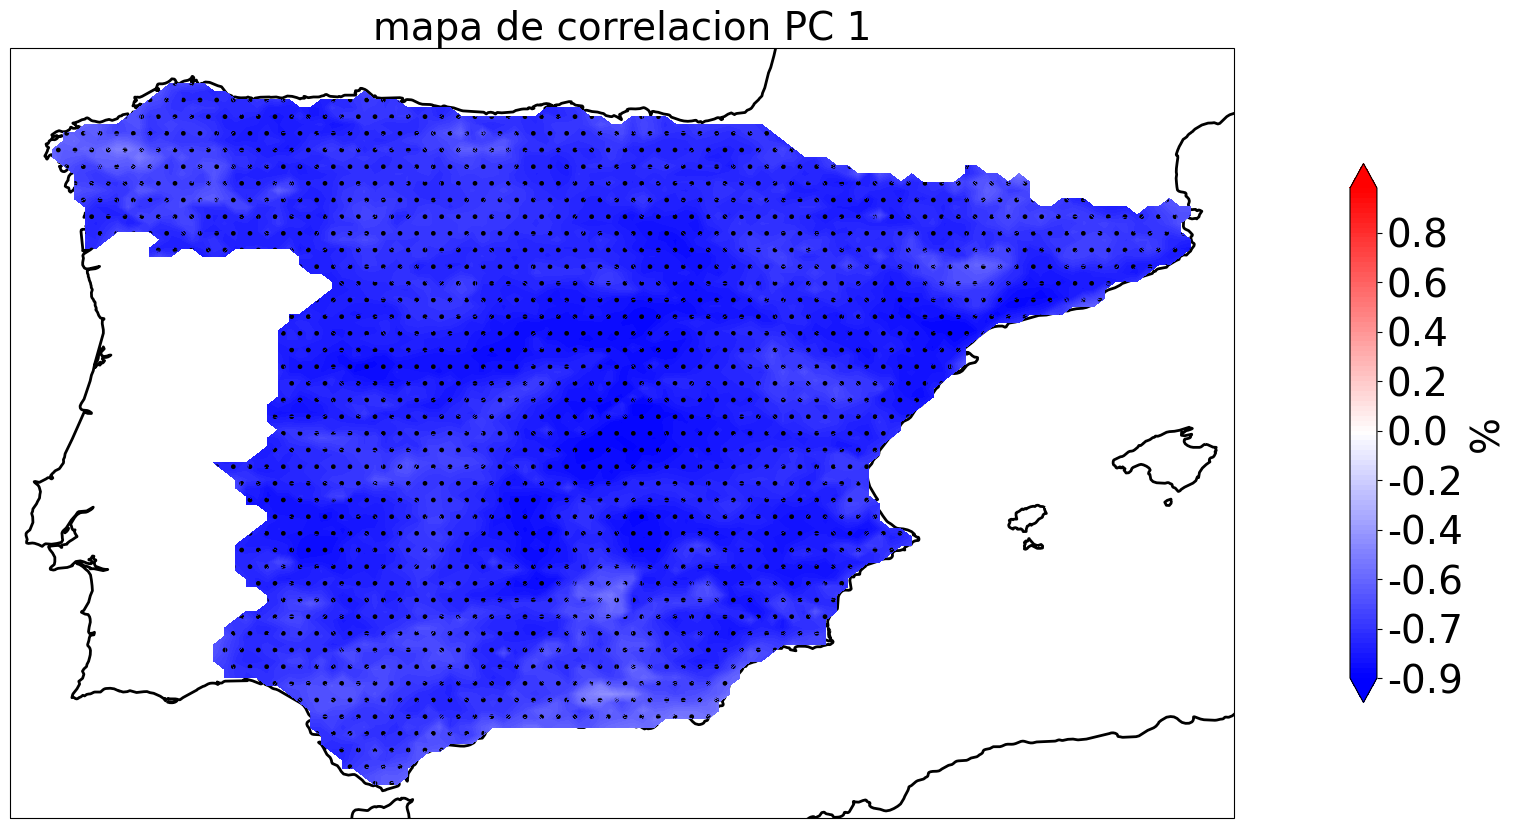

In [276]:
rango_reg=max(abs(np.nanmin(cor1_final)),abs(np.nanmax(cor1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(cor1_final,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de correlacion PC 1', ax)
ax.contourf(lon,lat,np.reshape(cor_sig1_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

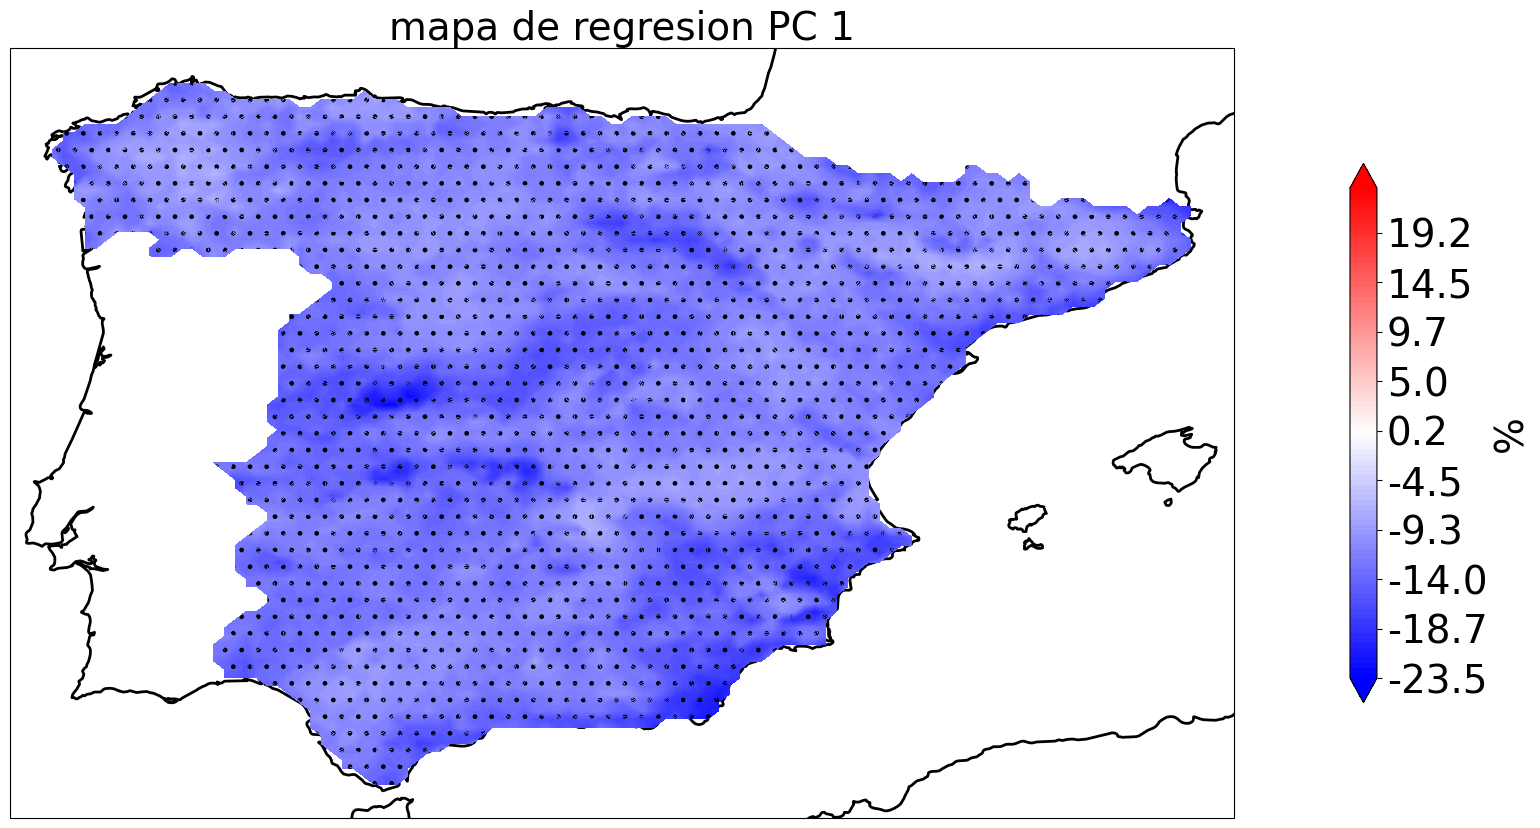

In [277]:
rango_reg=max(abs(np.nanmin(reg1_final)),abs(np.nanmax(reg1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1_final,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de regresion PC 1', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_1_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

Cuando hace frío hace frío en toda españa a la vez. No hay dipolos en el mapa.

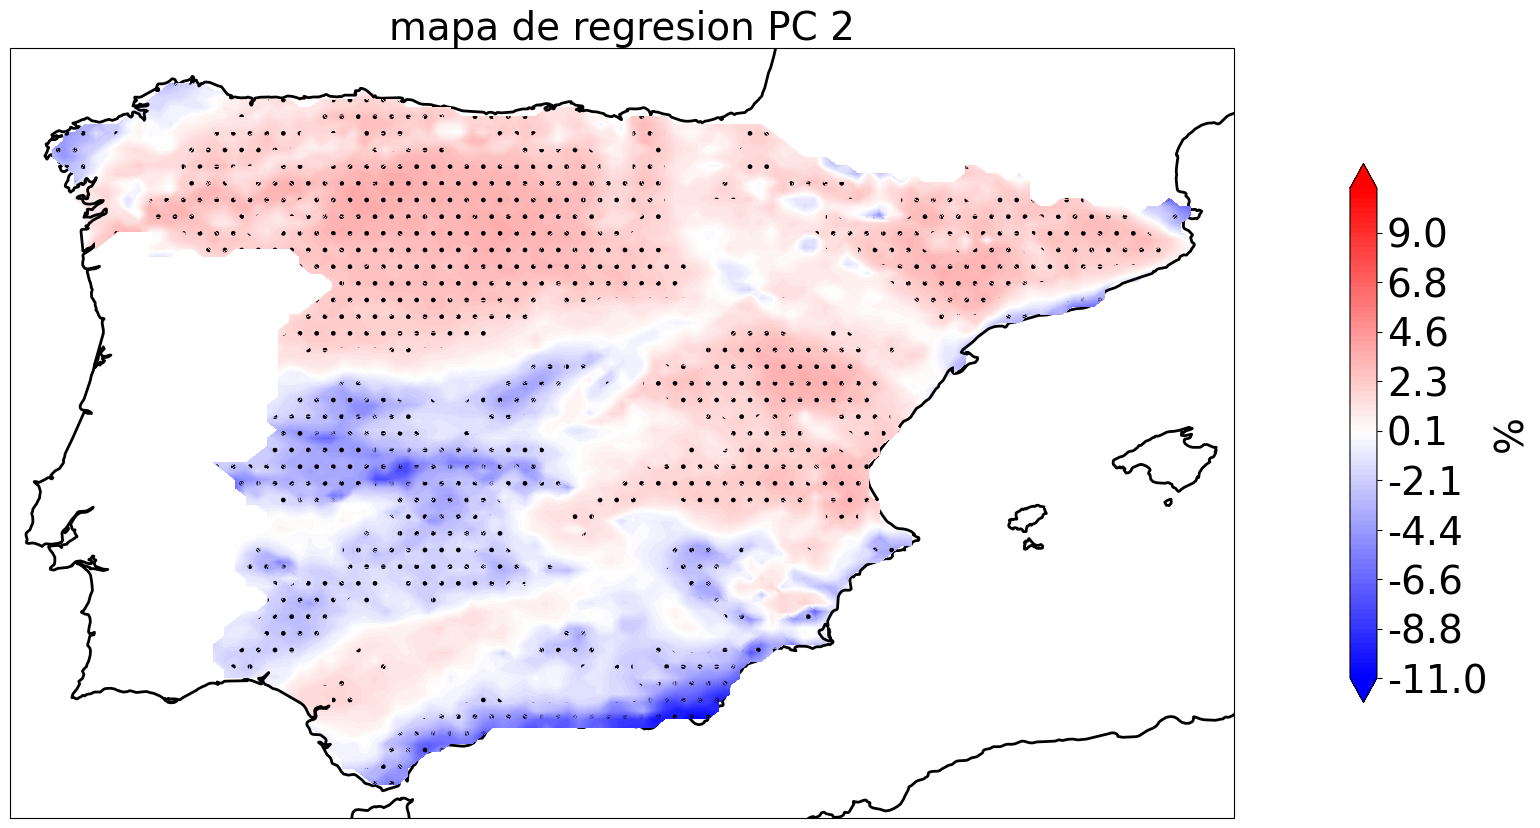

In [278]:
rango_reg=max(abs(np.nanmin(reg2_final)),abs(np.nanmax(reg_sig_2_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg2_final,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de regresion PC 2', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_2_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

En este mapa se ve un dipolo. Cuando hay color rojo en el norte, indica un aumento en porcentaje de días fríos, por lo tanto indica más fríos, mientras que el color azul indica una diminución de días fríos en zonas más al sur, es decir una disminución del frío.

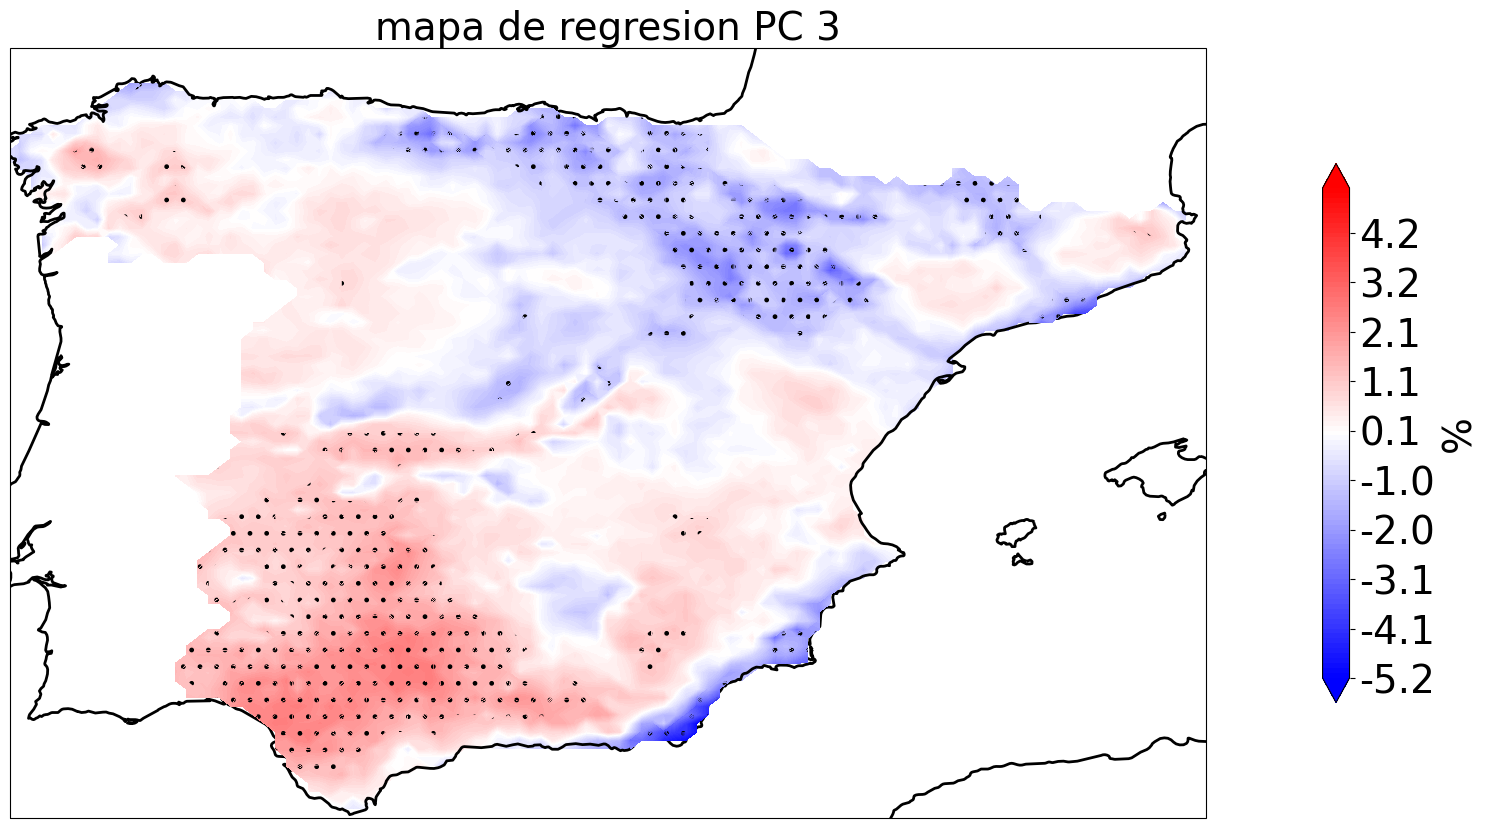

In [279]:
rango_reg=max(abs(np.nanmin(reg3_final)),abs(np.nanmax(reg_sig_3_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg3_final,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de regresion PC 3', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_3_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')

Este mapa nos dice que cuando hay un aumento de porcentaje de días fríos en el sur, hay una disminución de días fríos en zonas más al norte, aquí también se tiene una especie de dipolo.

Recontrucción de un año

In [280]:
tn10_primavera.shape

(114, 10925)

In [281]:
Y=tn10_primavera[primer_pico_P1]
primer_pico_P1
Y.shape

(10925,)

Text(0.5, 1.0, 'añoprimerpicopc1')

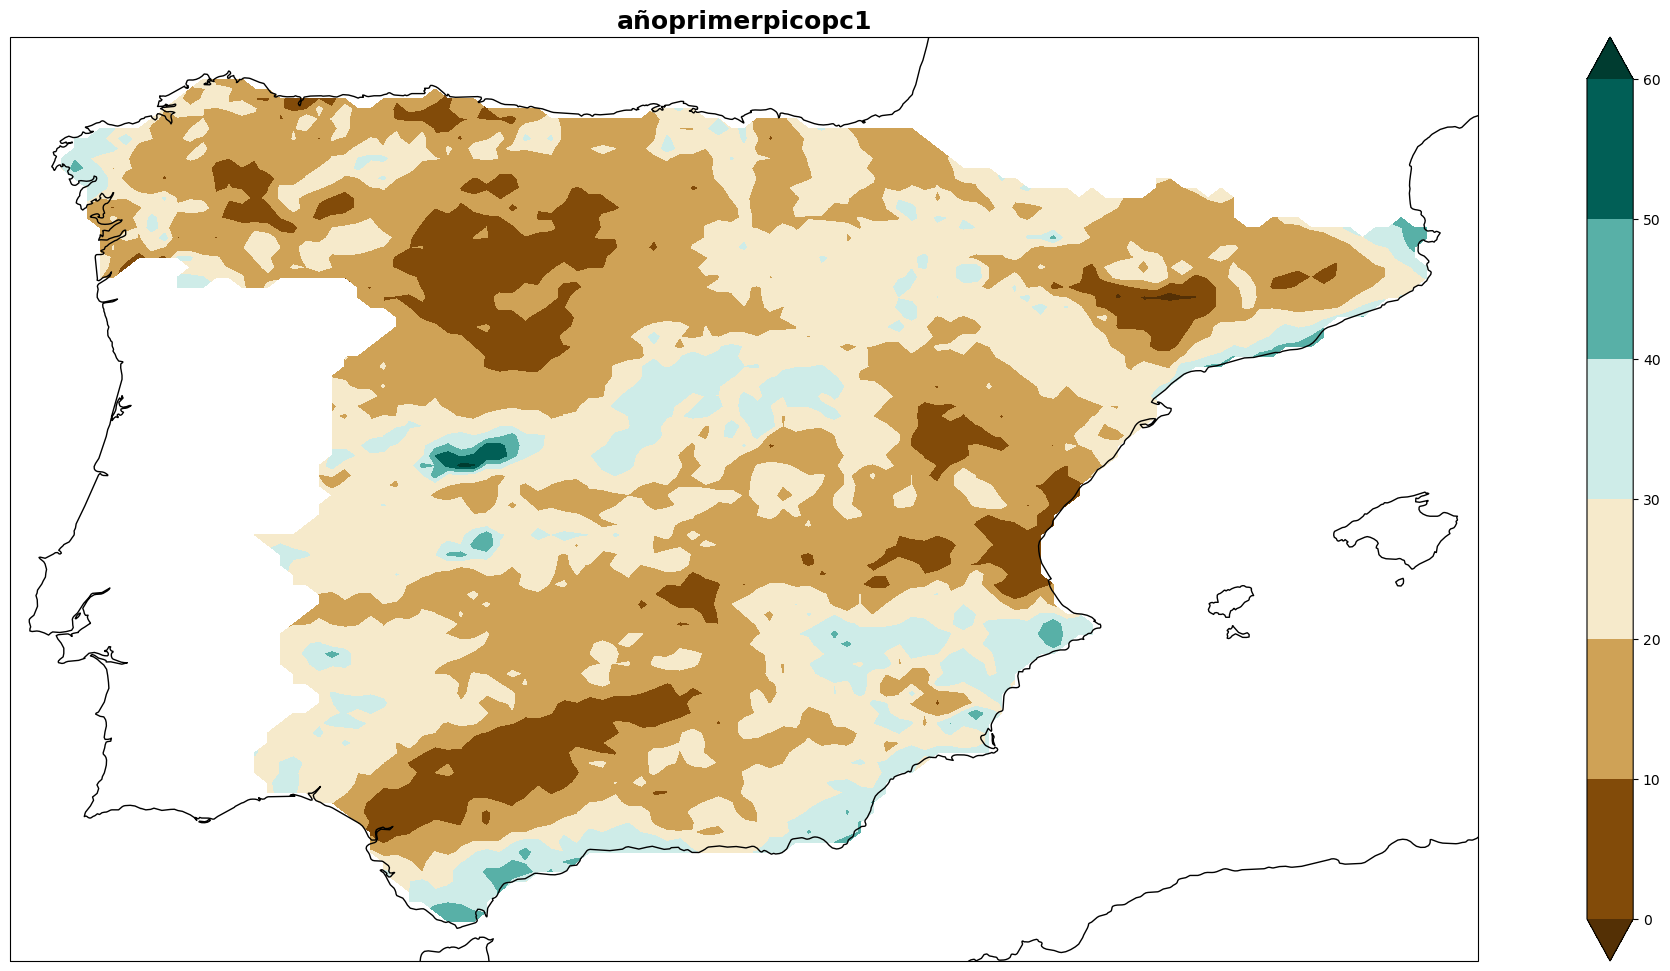

In [282]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Y.reshape(len(lat),len(lon)),cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('añoprimerpicopc1',fontsize=18,weight='bold')

In [283]:
PCs[primer_pico_P1,0]

-9.170599912086356

Text(0.5, 1.0, 'SLP 2006 reconstruida con PC1+PC2+PC3+PC4+PC5')

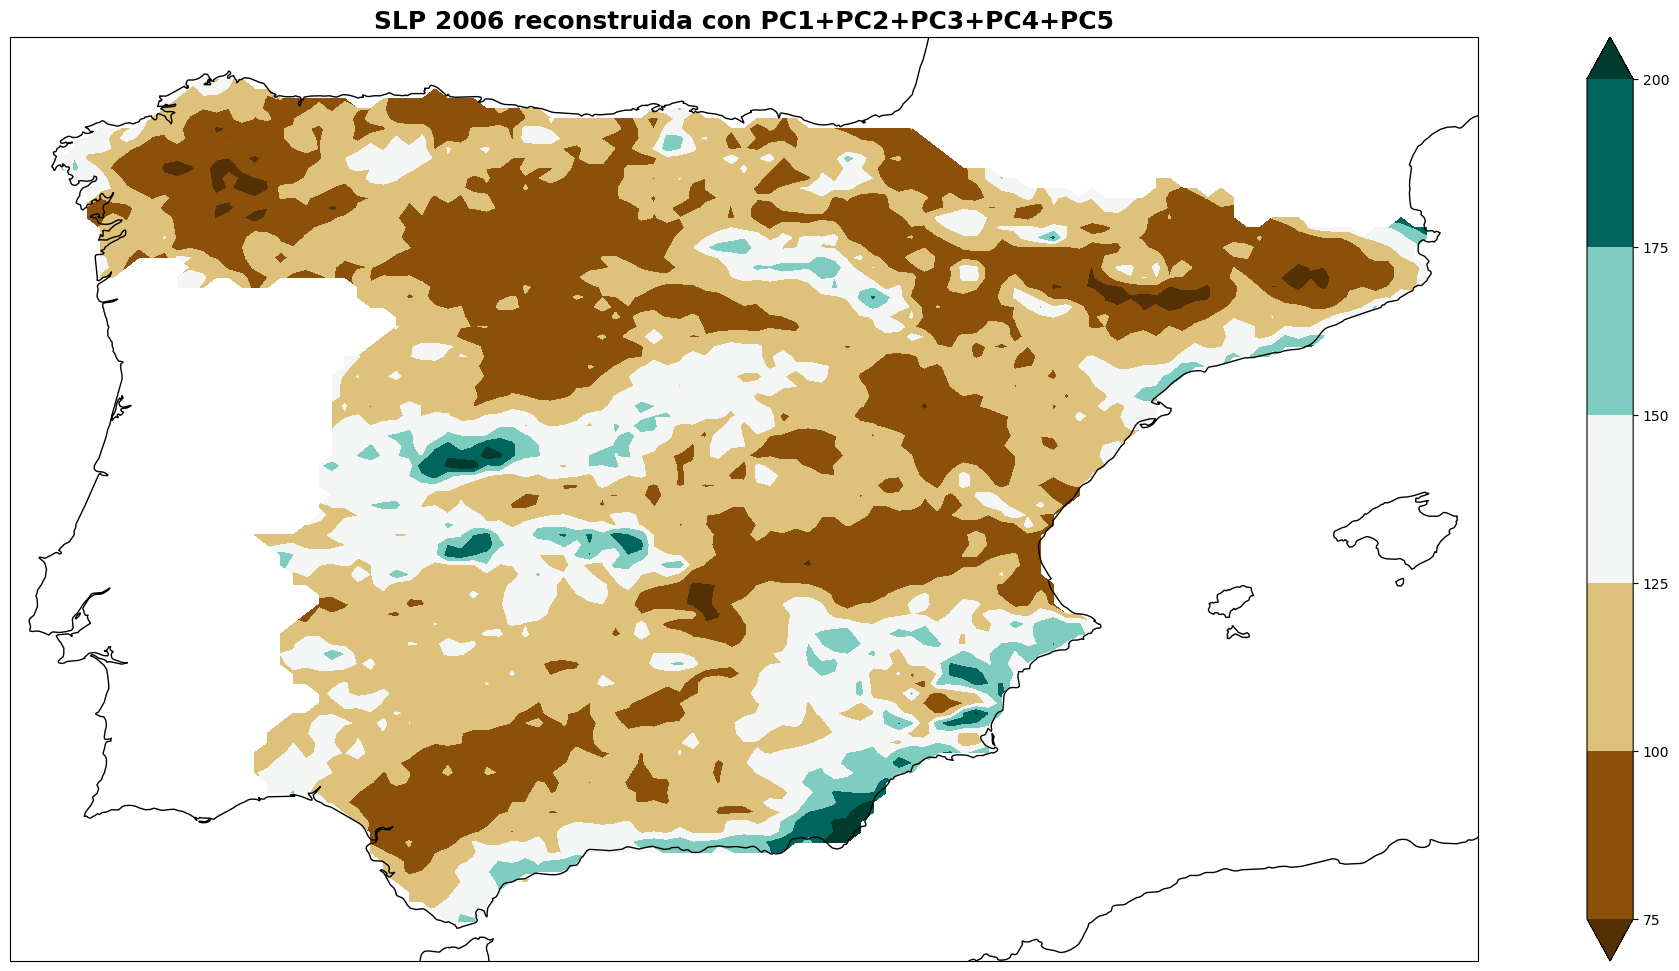

In [284]:
#recontruimos con 1 modo
Yreconst=reg1_final*PCs[primer_pico_P1,0]+reg2_final*PCs[primer_pico_P1,1]+reg3_final*PCs[primer_pico_P1,2]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Yreconst.reshape(len(lat),len(lon)),cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP 2006 reconstruida con PC1+PC2+PC3+PC4+PC5',fontsize=18,weight='bold')

### ¿Cómo se relacionan las EOFs con los índices de las diferntes regiones y con los índices de El Niño, la NAO, y las PCS de la SST y la SLP?

In [285]:

path_slp= '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/ERA20/slp_ERA20_1900-2010.nc'
slp_file= xr.open_dataset(path_slp)
slp_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-01-20 17:20:20 GMT by grib_to_netcdf-2.0.2: grib_to_ne...

In [286]:
# Vamos a tomar los puntos en Azores y en Islandia
Azores= [35, 335] #Ponta Delgada (São Miguel)
Islandia= [64.136319, 360-21.948231] #Reyjavick (o como se escriba)
escala= 1/100 #para tener la presión en hPa
Azores_point= slp_file.msl.sel(latitude=Azores[0],longitude=Azores[1],method='nearest')*escala
Islandia_point= slp_file.msl.sel(latitude=Islandia[0],longitude=Islandia[1],method='nearest')*escala
tiempo= slp_file.time

In [287]:
#ahora tomamos la anomalía estandarizada de presión entre estas dos estaciones
diferencia_presion= Azores_point-Islandia_point
#NAO= (diferencia_presion- diferencia_presion.mean())/diferencia_presion.std()
#hacemos la media y std por meses
NAO=((diferencia_presion.groupby('time.month')-diferencia_presion.groupby('time.month').mean('time'))).groupby('time.month')/diferencia_presion.groupby('time.month').std('time')
NAO

<xarray.DataArray 'msl' (time: 1332)>
array([ 0.74976099, -1.09638641, -1.86762482, ..., -0.22634874,
       -1.13392175, -2.87750959])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [288]:
TIEMPO = tiempo.indexes['time'].normalize()
TIEMPO

DatetimeIndex(['1900-01-01', '1900-02-01', '1900-03-01', '1900-04-01',
               '1900-05-01', '1900-06-01', '1900-07-01', '1900-08-01',
               '1900-09-01', '1900-10-01',
               ...
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
               '2010-11-01', '2010-12-01'],
              dtype='datetime64[ns]', name='time', length=1332, freq='MS')

<BarContainer object of 1332 artists>

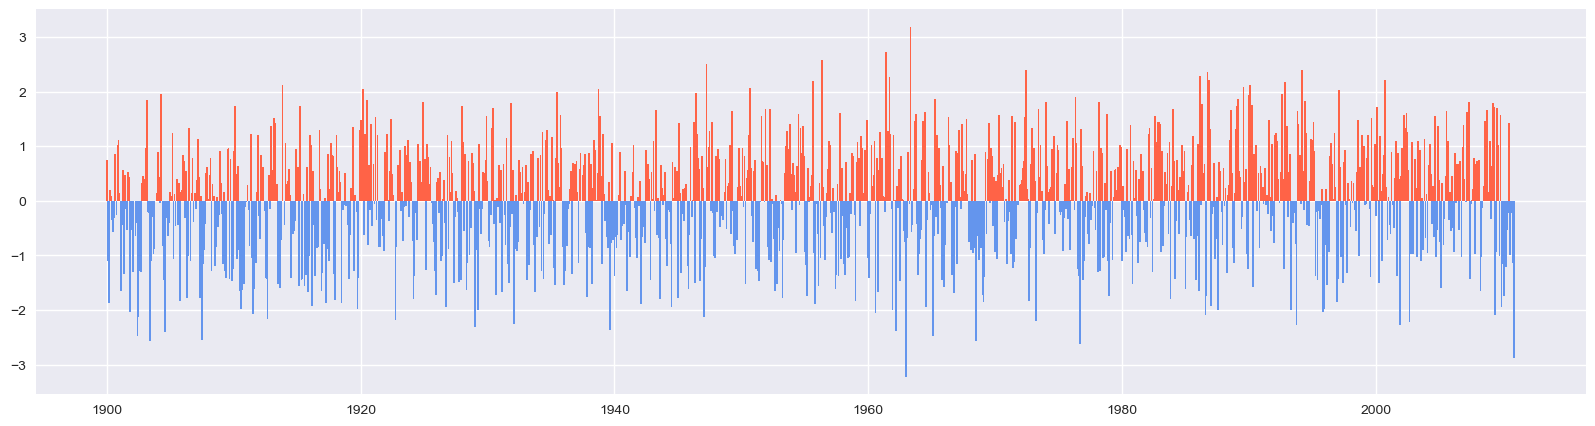

In [289]:
plt.style.use('seaborn')
fig, ax= plt.subplots(figsize=(20,5))
ax.bar(tiempo.indexes['time'].normalize(),NAO,width=50,color=np.where(NAO>0,'tomato','cornflowerblue'))

In [290]:
path_sst= '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/HadISST1/HadISST1_sst_1870-2019.nc'
sst_file= xr.open_dataset(path_sst)
sst_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [291]:
lon_nino= [-150,-90]
lat_nino= [5,-5]


nino_3_region= sst_file.sel(latitude=slice(lat_nino[0],lat_nino[1]),longitude=slice(lon_nino[0],lon_nino[1]))
#calculamos la media espacial de SST para cada tiempo y calculamos la anomalía
nino_3= nino_3_region.sst.mean(axis=(1,2))
nino_3_region

<xarray.Dataset>
Dimensions:    (longitude: 60, latitude: 10, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -149.5 -148.5 -147.5 ... -92.5 -91.5 -90.5
  * latitude   (latitude) float32 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 26.08 26.04 ... 23.08 23.12
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [292]:
ANOMALIA_nino_3= ((nino_3.groupby('time.month')-nino_3.groupby('time.month').mean('time'))).groupby('time.month')/nino_3.groupby('time.month').std('time')
ANOMALIA_nino_3

<xarray.DataArray 'sst' (time: 1800)>
array([-1.31801861, -1.37176839, -0.87842486, ...,  0.23864259,
        0.56651978,  0.34075136])
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [293]:
invierno_nino= ANOMALIA_nino_3.groupby('time.season')['DJF']
primavera_nino= ANOMALIA_nino_3.groupby('time.season')['MAM']
verano_nino= ANOMALIA_nino_3.groupby('time.season')['JJA']
otono_nino= ANOMALIA_nino_3.groupby('time.season')['SON']

invierno_NAO= NAO.groupby('time.season')['DJF']
primavera_NAO= NAO.groupby('time.season')['MAM']
verano_NAO= NAO.groupby('time.season')['JJA']
otono_NAO= NAO.groupby('time.season')['SON']

In [294]:
#Reducimos los datos para la comparación entre los dos índices a entre 1985-2000
invierno_NAO_red= invierno_NAO[(invierno_NAO.time.dt.year<=2000)&(invierno_NAO.time.dt.year>=1985)]
primavera_NAO_red= primavera_NAO[(primavera_NAO.time.dt.year<=2000)&(primavera_NAO.time.dt.year>=1985)]
verano_NAO_red= verano_NAO[(verano_NAO.time.dt.year<=2000)&(verano_NAO.time.dt.year>=1985)]
otono_NAO_red= otono_NAO[(otono_NAO.time.dt.year<=2000)&(otono_NAO.time.dt.year>=1985)]

invierno_nino_red= invierno_nino[(invierno_nino.time.dt.year<=2000)&(invierno_nino.time.dt.year>=1985)]
primavera_nino_red= primavera_nino[(primavera_nino.time.dt.year<=2000)&(primavera_nino.time.dt.year>=1985)]
verano_nino_red= verano_nino[(verano_nino.time.dt.year<=2000)&(verano_nino.time.dt.year>=1985)]
otono_nino_red= otono_nino[(otono_nino.time.dt.year<=2000)&(otono_nino.time.dt.year>=1985)]

<AxesSubplot:title={'center':'Índices del Niño 3 y la NAO para otoño'}>

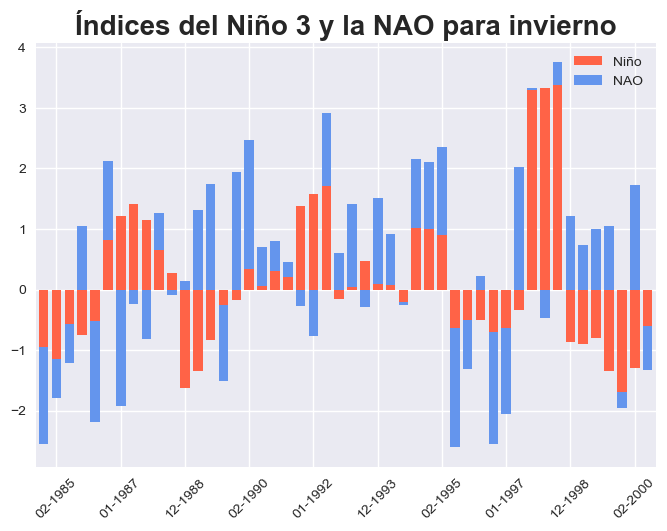

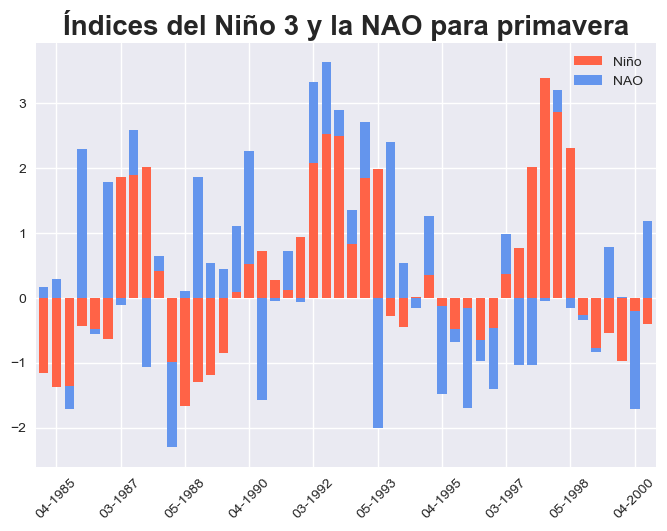

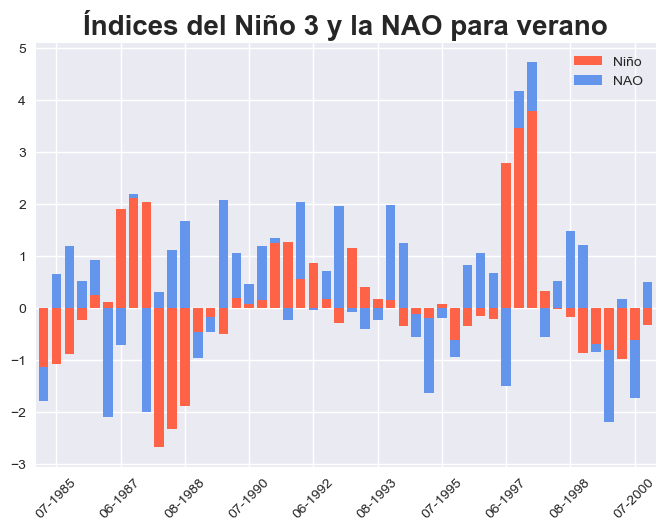

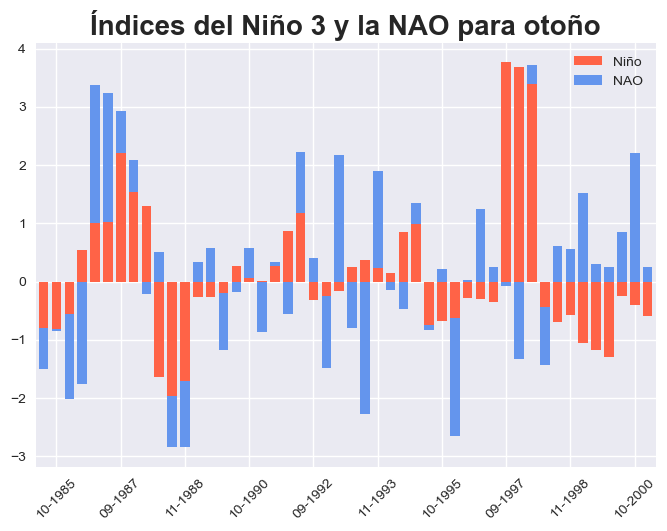

In [295]:
def data_arrays_topandasbarplot(niño,nao,estacion):
    testdata = pd.DataFrame({'Niño':niño, 'NAO':nao},index=pd.to_datetime(niño.time))
    testdata.index = [d.strftime("%m-%Y") for d in testdata.index]
    ax= testdata.plot.bar(rot=45,color={"Niño": "tomato", "NAO": "cornflowerblue"},width=0.75,stacked='True')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.set_title('Índices del Niño 3 y la NAO para '+str(estacion),size=20,weight='bold')
    return ax

data_arrays_topandasbarplot(invierno_nino_red,invierno_NAO_red,'invierno')
data_arrays_topandasbarplot(primavera_nino_red,primavera_NAO_red,'primavera')
data_arrays_topandasbarplot(verano_nino_red,verano_NAO_red,'verano')
data_arrays_topandasbarplot(otono_nino_red,otono_NAO_red,'otoño')

In [319]:
#veamos si mi indice DE EL NIÑO EN PRIMAVERA se parece a la eof
primavera_nino_red= primavera_nino[(primavera_nino.time.dt.year<=2000)&(primavera_nino.time.dt.year>=1985)]
primavera_nino_red_reshape=np.reshape(np.asarray(primavera_nino_red),(int(primavera_nino_red.shape[0]/3),3)).mean(axis=1)

A=primavera_nino_red_reshape
year=np.arange(1900,2014)
PC119712010=PCs[85:101,0]
b=pearsonr(A,PC119712010)
print(b)

(0.0736302587699248, 0.7863929813590035)


In [320]:
#veamos si mi indice DE LA NAO EN PRIMAVERA se parece a la eof
primavera_NAO_red= primavera_NAO[(primavera_NAO.time.dt.year<=2000)&(primavera_NAO.time.dt.year>=1985)]
primavera_NAO_red_reshape=np.reshape(np.asarray(primavera_NAO_red),(int(primavera_NAO_red.shape[0]/3),3)).mean(axis=1)

A=primavera_NAO_red_reshape
year=np.arange(1900,2014)
PC119712010=PCs[85:101,0]
b=pearsonr(A,PC119712010)
print(b)

(-0.2602295720975671, 0.3303586514673342)


In [172]:
def MCA(Z,Y,nmes,nm,meth,alfa,sig,perm):
     # Z: campo a predecir
    # Y: campo predictor
    # datos con dimensiones ns, nt
    # nm: numero de modos
    # nmes: meses por año, si es media estacional es 1, pero si es enero y feb
    #por separado es 2
    # meth: metodología
    # Y1, Z1: campos sobre los que proyecto los resultados, 
    #que pueden ser para un espacio mayor que en Z e Y
    
    nz,nt=Z.shape
    ny,nt=Y.shape
    nyr=int(nt/nmes)
    # matriz de covarianza
    if  meth=='MCA':
        C=np.dot(Y,np.transpose(Z))
    
    if  meth =='CCA':
        iSYY=inv(np.dot(Y,np.transpose(Y)))
        SYZ=np.dot(Y,np.transpose(Z))
        iSZZ=inv(np.dot(Z,np.transpose(Z)))
        SZY=np.dot(Z,np.transpose(Y))
        C=np.dot(np.dot(iSYY,SYZ), np.dot(iSZZ,SZY))
    
    R,d,Q=linalg.svd(C) # R son los autovectores de y Q son los autovectores de Z
    scf=d/np.sum(d)
    

    # coefs de expansión
    U=np.dot(np.transpose(Y),R[:,:nm])
    V=np.dot(np.transpose(Z),Q[:,:nm])
    
    # coefs de expansión estandarizados
    Us=anom(np.transpose(U),nyr,'st')
    Vs=anom(np.transpose(V),nyr,'st')
    
    RUY=ma.empty([ny,nm]);pvalruy=ma.empty([ny,nm]);RUY_sig=ma.empty([ny,nm]);SUY=ma.empty([ny,nm]);SUY_sig=ma.empty([ny,nm])
    RUZ=ma.empty([nz,nm]);pvalruz=ma.empty([nz,nm]);RUZ_sig=ma.empty([nz,nm]);SUZ=ma.empty([nz,nm]);SUZ_sig=ma.empty([nz,nm])
    for i in range(nm):
        RUY[:,i], pvalruy[:,i], RUY_sig[:,i], SUY[:,i], SUY_sig[:,i]=IndexRegrCorr(Y,Us[i,:],alfa,sig,perm)
        RUZ[:,i], pvalruz[:,i], RUZ_sig[:,i], SUZ[:,i], SUZ_sig[:,i]=IndexRegrCorr(Z,Us[i,:],alfa,sig,perm)

    return RUY,RUY_sig,SUY,SUY_sig,RUZ,RUZ_sig,SUZ,SUZ_sig,Us,Vs,scf


def dibujo_timeserie(ax,TS,time,ylabel,xlabel,title):
    ax.plot(time,TS,linewidth=6)
    ax.grid(b=True, linestyle ='--')
    plt.xticks(np.arange(time[0],time[-1],20))
    ax.tick_params('y',labelsize = 14, width = 2, length = 10)
    ax.tick_params('x',labelsize = 12, width = 2, length = 10, labelrotation = 60)
    ax.legend(loc=3,fontsize=14)
    ax.set_title(title, fontsize = 16, weight ='bold')
    ax.set_ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 14, fontweight = 'bold')


def dibujo_timeserie_confiltro(ax,time,sig,low,low_det,high,xlabel,ylabel,title):
    ax.plot(time,sig,label ='raw')
    ax.plot(time,low,label ='low')
    ax.plot(time,high,label ='high')
    ax.plot(time,low_det,label ='low_det')
    ax.grid(b=True, linestyle ='--')
    plt.xticks(np.arange(time[0],time[-1],20))
    ax.tick_params('y',labelsize = 14, width = 2, length = 10)
    ax.tick_params('x',labelsize = 12, width = 2, length = 10, labelrotation = 60)
    ax.legend(loc=3,fontsize=14)
    ax.set_title(title, fontsize = 16, weight ='bold')
    ax.set_ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 14, fontweight = 'bold');


def filtro(nyc,n,Wn,TS):
#Wn= 2*dt/nyc
    b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
    #Filtro la señal ampliada y me quedo con la parte central:
    low = signal.filtfilt(b,a,TS)
    b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
    #Filtro la señal ampliada y me quedo con la parte central:
    high = signal.filtfilt(b,a,TS)
    return high,low

In [396]:
#Voy a usar los datos SST y SLP como en la practica 3
#Cargo los datos SST:
path='/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/HadISST1/'
vari='HadISST1_sst_1870-2019.nc'
fil = xr.open_dataset(path+vari)
lon = fil.longitude
lat = fil.latitude
sst = fil.sst
nt, nlat, nlon = sst.shape
nm = 12
nyearssst = int(nt/nm)

#SLP
path2='/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/ERA20/'
vari2='slp_ERA20_1900-2010.nc'
fil2 = xr.open_dataset(path2+vari2) #Air preassure at sea level
slp=fil2.msl #OJO QUE LAS LONGITUDES ESTAN MOVIDAS 180 grados respecto a las SST
slplat=fil2.latitude
slplon=fil2.longitude
nt1, nlat1, nlon1 = slp.shape
print(slp.shape) #Tengo menos años, ojo al hacer la covarianza con el niño!
#111,181,360

nyears=111

(1332, 181, 360)


In [397]:
def region(data,lat,lon,lonmin,lonmax,latmin,latmax):
    # data[t,lon,lat]
    latc=lat[(lat>=latmin)&(lat<=latmax)]
    lonc=lon[(lon>=lonmin)&(lon<=lonmax)]
    datac = data[:,:,(lon>=lonmin)&(lon<=lonmax)][:,(lat>=latmin)&(lat<=latmax),:]
    return datac,latc,lonc

In [398]:
slplon

<xarray.DataArray 'longitude' (longitude: 360)>
array([  0.,   1.,   2., ..., 357., 358., 359.], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [399]:
#Las longitudes de SLP estan corridas 180 grados respecto a las SST
lonSLP=slplon-180
ntslp, nlatslp, nlonslp = slp.shape
slp=np.roll(slp,int(nlonslp/2)) # mueve los datos para centrarlos en 0
lonmin,lonmax,latmin,latmax = -270, -70, -20, 20
lonmin1,lonmax1,latmin1,latmax1 = -50, 10, 20, 80
slp,lat1,lon1=region(slp,slplat,lonSLP,lonmin1,lonmax1,latmin1,latmax1)

yrslp=np.linspace(1900,2010,111) # los años de los datos van hasta el 2010
yrtn=np.linspace(1900,2014,114) # los años de los datos van hasta el 2014
yrsst=np.linspace(1870,2019,150)

tn10_slp=tn10_remallado[:111,:] # coger hasta el año 150*12 porque no acaban en 2020 pero no tienen todos los meses, acabar al final del año 150
tn10_slp.shape

(111, 95, 115)

In [400]:
SST,lat,lon=region(sst,lat,lon,lonmin,lonmax,latmin,latmax)
SST=SST[:150*12,:,:] # coger hasta el año 150*12 porque no acaban en 2020 pero no tienen todos los meses, acabar al final del año 150
SST=np.array(SST)
SST=np.reshape(SST, (150,12,len(lat),len(lon)))
SST.shape


(150, 12, 40, 110)

In [401]:
SST2=SST[(yrsst>=yrslp.min()) & (yrsst<=yrslp.max()),:,:,:]

In [403]:
# Z1998=SST2[yrslp==1998,0,:,:]
# fig = plt.figure(figsize=(22,8)) 
# dibujo_1_mapa_cartopy(Z1998,lon,lat,np.arange(10,30), 'bwr', '')

In [348]:
tn10_slp.shape

(111, 95, 115)

In [349]:
slp.shape

(1332, 61, 61)

In [350]:
slp2=np.reshape(slp, (111,12,len(lon1)*len(lat1)))
slp2_sea,ny2=season(slp2,2,4,nyrs)
slp2_sea_an=anom(np.transpose(slp2_sea),1,'pp')

In [351]:
def dibujo_1_mapa_cartopy(A,lon,lat, levs, cmap1, l1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))

    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon))
                 ,cmap=cmap1,levels=levs,extend='both',transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores

In [352]:
slp2_sea_an.shape

(3721, 111)

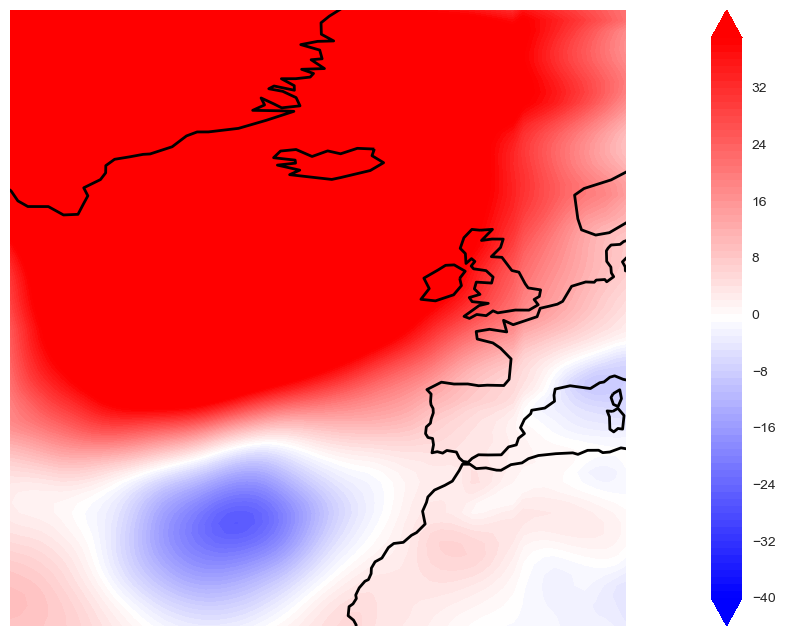

In [353]:
fig = plt.figure(figsize=(22,8)) 
dibujo_1_mapa_cartopy(slp2_sea_an[:,0]/10,lon1,lat1,np.arange(-40,40), 'bwr', '')

In [354]:
#veamos si mi indice DE LA NAO EN PRIMAVERA se parece a la eof
A=slp2_sea_an[:110,0]
PC119712010=PCs[:110,0]
b=pearsonr(A,PC119712010)
print(b)

(-0.3297219254700714, 0.0004355500832199823)


In [355]:
print(slp2_sea_an.shape)
tn10_slp___=tn10_slp.transpose()
tn10_slp_reshape=np.reshape(np.asarray(tn10_slp___),(nlat*nlon,111))


(3721, 111)


In [356]:
nmes=1 #bloques por año
#nm=1 # numero de modos
# se hace esto porque no puede trabajr con nans
Z1=np.nan_to_num(tn10_slp_reshape,nan=-999) # campo a predecir matriz de extremos
Y1=np.nan_to_num(slp2_sea_an,nan=-999) # campo predictor matriz SLP
# poniendo Y1.data te quita la mascara en caso de que la haya, que puede dar problemas
RUY,RUY_sig,SUY,SUY_sig,RUZ,RUZ_sig,SUZ,SUZ_sig,Us,Vs,scf=MCA(np.asarray(Z1),np.asarray(Y1),nmes,3,'MCA',0.1,'MonteCarlo',100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


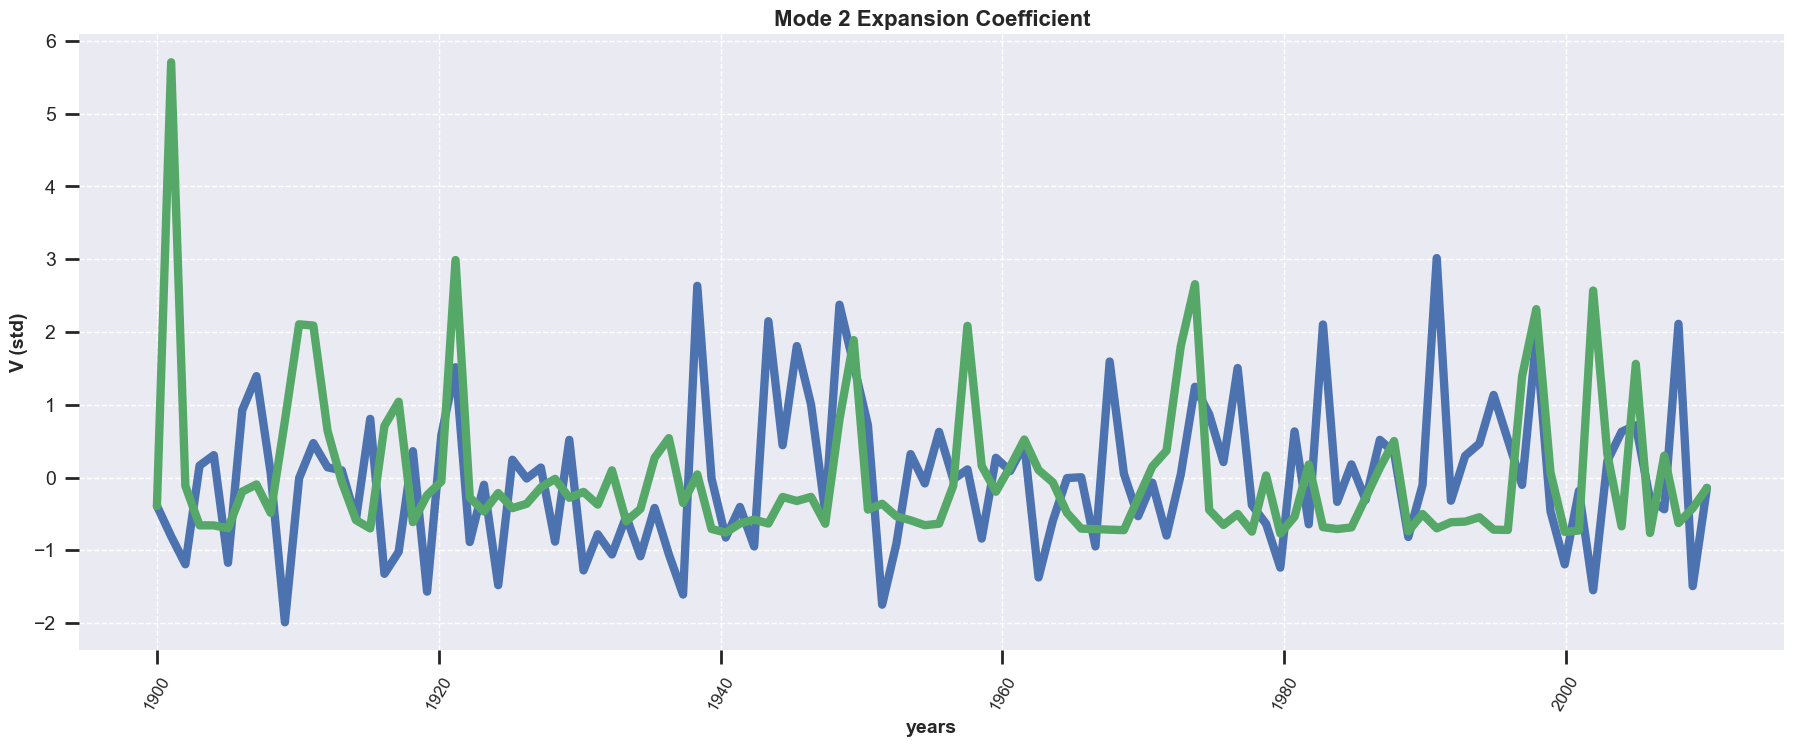

In [357]:
fig = plt.figure(figsize=(22,8)) 
ax=fig.add_subplot(1, 1, 1)
dibujo_timeserie(ax,Us[1,:110],yrslp[:110],'U (std)','years','Mode 2 Expansion Coefficient')
dibujo_timeserie(ax,Vs[1,:110],yrslp[:110],'V (std)','years','Mode 2 Expansion Coefficient')

In [358]:
r=pearsonr(np.transpose(Us[1,:]),np.transpose(Vs[1,:]))
r

(0.035157708233969714, 0.7141190837891728)

In [359]:
scf[0]

0.2507388202922205

In [360]:
SUZ.shape
lon1.shape
lat1.shape

(61,)

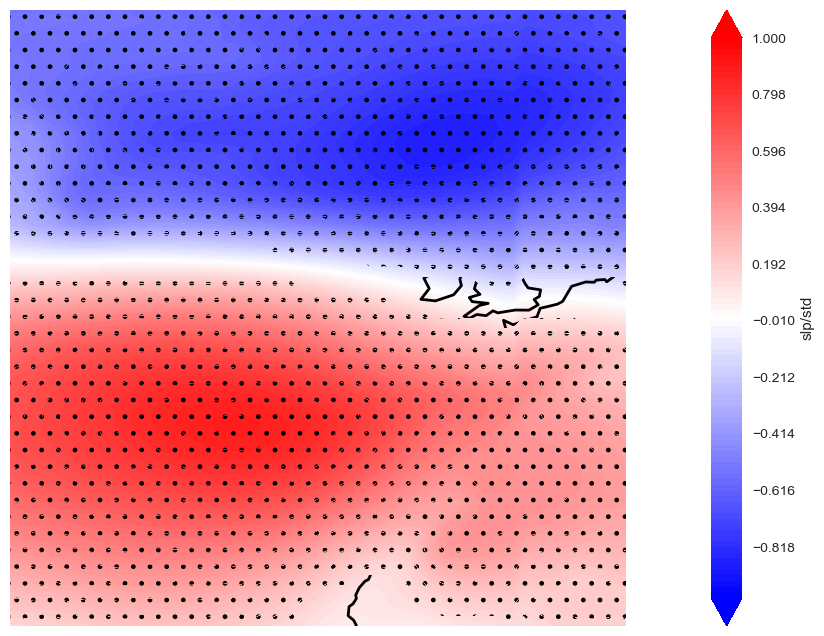

In [361]:
fig = plt.figure(figsize=(22,8)) 
dibujo_2_mapas_cartopy_hatches(RUY[:,0],RUY_sig[:,0],lon1,lat1,np.linspace(-1,1,100),'bwr', 'slp/std', 'mapa heterogéneo')

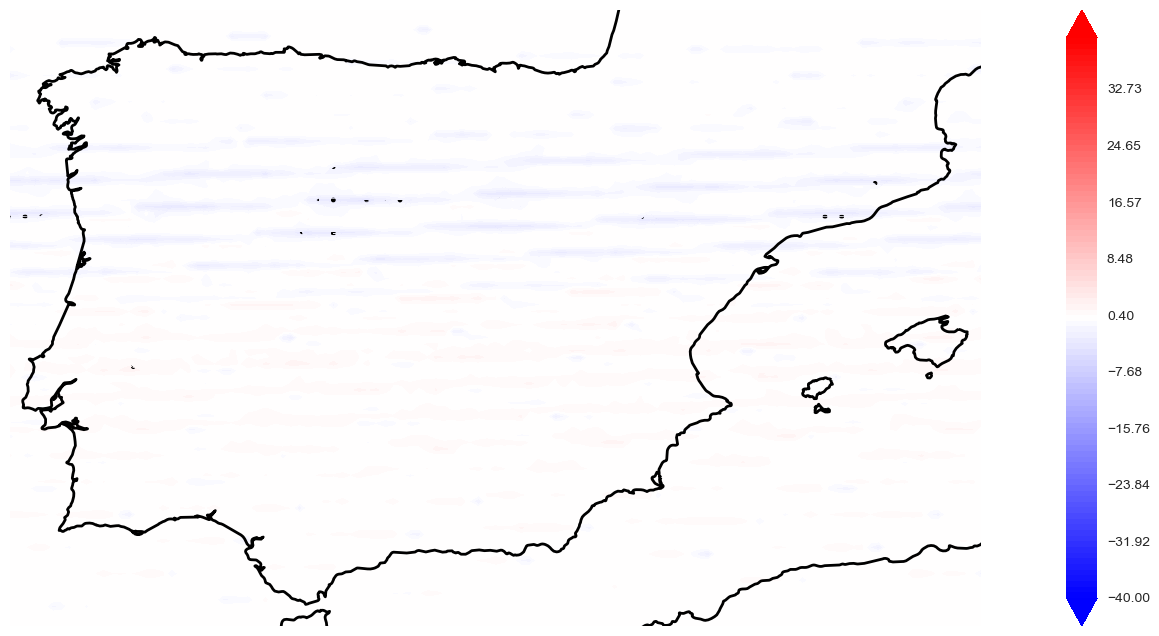

In [362]:
fig = plt.figure(figsize=(22,8)) 
dibujo_2_mapas_cartopy_hatches(SUZ[:,0],SUZ_sig[:,0],lon,lat,np.linspace(-40,40,100),'bwr', '','')

In [404]:
# Ahora voy a calcular las anomalias
SST2=np.reshape(SST2, (nyears,12,len(lon)*len(lat)))
SST2_sea,ny1=season(SST2,6,8,111)
SST2_sea_an=anom(np.transpose(SST2_sea),111,'pp')
# 111 un dato por año
# pp que no las haga estadarizadas